### <div class="alert alert-info" align="center">Amazon Reviews Capstone Project</div>

In [1]:
#importing required libraries
import pandas as pd
import json
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import recall_score,f1_score,accuracy_score,precision_score,confusion_matrix,classification_report,silhouette_score
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.facecolor':'lightblue'})
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
import fasttext
from time import time
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import scipy.cluster.hierarchy as sch
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf 
from statsmodels.tsa.arima.model import ARIMA,sarimax
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
import statsmodels.api as sm
from tqdm.notebook import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer
from langdetect import detect

C:\Users\aksha\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#loading main data
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF("C:/Users/aksha/Downloads/Video_Games_5.json.gz")

In [8]:
#loading rating data
r1=pd.read_csv(r"C:\Users\aksha\Downloads\Video_Games.csv",names=['item','user','rating','timestamp'])
r1.head()

,item,user,rating,timestamp
0,0439381673,A21ROB4YDOZA5P,1.0,1402272000
1,0439381673,A3TNZ2Q5E7HTHD,3.0,1399680000
2,0439381673,A1OKRM3QFEATQO,4.0,1391731200
3,0439381673,A2XO1JFCNEYV3T,1.0,1391731200
4,0439381673,A19WLPIRHD15TH,4.0,1389830400


### Main data

In [3]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4.0,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3.0,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2.0,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5.0,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- vote - helpful votes of the review
- style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)
- image - images that users post after they have received the product

In [15]:
df[df["overall"]==3]["reviewText"].values[4]

"This game is way too easy for adults.  For kids, it's great.  I wish they made one for adults though with more difficulty levels."

In [6]:
df["reviewText"].values[0]

"This game is a bit hard to get the hang of, but when you do it's great."

In [197]:
df.shape

(497577, 12)

In [198]:
df.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'style', 'image'],
      dtype='object')

In [199]:
df.describe()

,overall,unixReviewTime
count,497577.000000,4.975770e+05
mean,4.220456,1.367848e+09
std,1.185424,1.224113e+08
min,1.000000,9.398592e+08
25%,4.000000,1.316563e+09
50%,5.000000,1.410221e+09
75%,5.000000,1.452384e+09
max,5.000000,1.538438e+09


In [200]:
df.dtypes

overall           float64
verified             bool
reviewTime         object
reviewerID         object
asin               object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
vote               object
style              object
image              object
dtype: object

In [201]:
df.isnull().sum()

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
reviewerName          76
reviewText           158
summary              109
unixReviewTime         0
vote              389784
style             208340
image             493943
dtype: int64

In [202]:
meta=pd.json_normalize(df['style'])
meta.head()

,Format:,Platform:,Edition:,Color:,Size:,Style:,Length:,Subscription Length:,Content:,Package Type:,Package Quantity:,Item Package Quantity:,Pattern:,Platform for Display:,Style Name:,Denomination:,Offer Type:,Configuration:,Color Name:
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [203]:
meta.isnull().sum()

Format:                   361749
Platform:                 390983
Edition:                  433575
Color:                    476595
Size:                     493135
Style:                    487222
Length:                   496203
Subscription Length:      496249
Content:                  497532
Package Type:             496581
Package Quantity:         497087
Item Package Quantity:    497537
Pattern:                  497408
Platform for Display:     497295
Style Name:               497353
Denomination:             497493
Offer Type:               497570
Configuration:            497313
Color Name:               497558
dtype: int64

In [204]:
df["reviewTime"]=pd.to_datetime(df["reviewTime"])

In [205]:
df.drop(["style","unixReviewTime","image","reviewerName","vote"],axis=1,inplace=True)

In [206]:
df.isnull().sum()

overall         0
verified        0
reviewTime      0
reviewerID      0
asin            0
reviewText    158
summary       109
dtype: int64

In [207]:
df.dropna(inplace=True)

In [208]:
df[df.duplicated(keep=False)]

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary
6847,4.0,False,2014-03-03,A2R164STV36F6C,B00002DHEV,After years of coveting my friends Super Ninte...,Nintendo Explores New Territory in 64-bit
6848,4.0,False,2014-03-03,A2R164STV36F6C,B00002DHEV,After years of coveting my friends Super Ninte...,Nintendo Explores New Territory in 64-bit
8315,4.0,False,2011-09-15,A36UKFV79879MD,B00002STX3,Aladdin was the mega popular Disney movie rele...,A pretty good game
8316,4.0,False,2011-09-15,A36UKFV79879MD,B00002STX3,Aladdin was the mega popular Disney movie rele...,A pretty good game
11364,5.0,False,2011-10-02,AER15RIMV8E6D,B000035Y3N,This is one of my all-time favorite SNES games...,One of my Favorite SNES Games!!!
...,...,...,...,...,...,...,...
454678,5.0,False,2003-04-22,A2N2ROALE43S54,B000066TSC,"First, let me point this out: those two bad re...","Some times you gotta be smart, immature reviewers"
462724,1.0,False,2007-03-25,A1XMMYFVGGLTC3,B000B6ML3W,I bought my original shiny new XBOX and many n...,Microsoft hates their customers (but loves mon...
462725,1.0,False,2007-03-25,A1XMMYFVGGLTC3,B000B6ML3W,I bought my original shiny new XBOX and many n...,Microsoft hates their customers (but loves mon...
489149,5.0,True,2015-04-12,A2FFZM2WCYDU3O,B00FUXZUPW,Thanks,Five Stars


In [209]:
df.drop_duplicates(inplace=True,ignore_index=True)

In [210]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary
0,5.0,True,2015-10-17,A1HP7NVNPFMA4N,0700026657,"This game is a bit hard to get the hang of, bu...",but when you do it's great.
1,4.0,False,2015-07-27,A1JGAP0185YJI6,0700026657,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it"
2,3.0,True,2015-02-23,A1YJWEXHQBWK2B,0700026657,ok game.,Three Stars
3,2.0,True,2015-02-20,A2204E1TH211HT,0700026657,"found the game a bit too complicated, not what...",Two Stars
4,5.0,True,2014-12-25,A2RF5B5H74JLPE,0700026657,"great game, I love it and have played it since...",love this game


In [211]:
df.shape

(473924, 7)

In [212]:
# Creating cleaning function
def cleaning(text):
    text = re.sub("[^0-9A-Za-z\-]+", " ", text) 
    text = re.sub("(?<!\w)\d+", "", text)
    text = re.sub("-(?!\w)", "", text)
    text = " ".join(text.split())
    text = text.lower()
    return text

In [213]:
df["reviewText"] = df["reviewText"].apply(cleaning)
df["summary"] = df["summary"].apply(cleaning)

In [214]:
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df['summary'] = df['summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [215]:
df["asin"].nunique()

17408

In [216]:
df["reviewerID"].nunique()

55216

In [217]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary
0,5.0,True,2015-10-17,A1HP7NVNPFMA4N,0700026657,game bit hard get hang great,great
1,4.0,False,2015-07-27,A1JGAP0185YJI6,0700026657,played alright steam bit trouble move game ste...,spite fun liked
2,3.0,True,2015-02-23,A1YJWEXHQBWK2B,0700026657,ok game,three stars
3,2.0,True,2015-02-20,A2204E1TH211HT,0700026657,found game bit complicated expected played,two stars
4,5.0,True,2014-12-25,A2RF5B5H74JLPE,0700026657,great game love played since arrived,love game


In [218]:
#saving the dataframe
df.to_csv("5core.csv",index=False)

### Meta Data 

In [5]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

m= getDF("C:/Users/aksha/Downloads/meta_Video_Games.json.gz")

In [6]:
m.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Video Games, PC, Games]",,[],,Reversi Sensory Challenger,[],,Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,,,0042000742,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
1,"[Video Games, Xbox 360, Games, </span></span><...",,[Brand new sealed!],,Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],,by\n \n EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,,"\n\t\t\t\t\t\t\t\t\t\t\t\t<span class=""vertica...",0078764343,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,"[Video Games, Retro Gaming & Microconsoles, Su...",,[],,street fighter 2 II turbo super nintendo snes ...,[],,Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,,$0.72,0276425316,[],[],NaN
3,"[Video Games, Xbox 360, Accessories, Controlle...",,[MAS's Pro Xbox 360 Stick (Perfect 360 Stick) ...,,Xbox 360 MAS STICK,[],,by\n \n MAS SYSTEMS,[Original PCB used from Xbox 360 Control Pad (...,"[>#105,263 in Video Games (See Top 100 in Vide...",[],Video Games,,,,0324411812,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
4,"[Video Games, PC, Games, </span></span></span>...",,"[Phonics Alive! 3, The Speller teaches student...",,Phonics Alive! 3: The Speller,[],,by\n \n Advanced Software Pty. Ltd.,"[Grades 2-12, Spelling Program, Teaches Spelli...","[>#92,397 in Video Games (See Top 100 in Video...",[B000BCZ7U0],Video Games,,,,0439335310,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN


In [575]:
m.shape

(84819, 19)

In [576]:
#count of empty list or empty sets or empty strings in each columns
counts = m.apply(lambda x: x.apply(lambda y: 1 if y == [] or y=='' or y=={} else 0).sum())
print(counts)

category            2425
tech1              81972
description        10159
fit                84819
title                 11
also_buy           49424
tech2              84585
brand               4027
feature            22871
rank                4500
also_view          39778
main_cat             120
similar_item       84538
date               74762
price              25460
asin                   0
imageURL           22863
imageURLHighRes    22863
details            82483
dtype: int64


In [577]:
m=m[["category","title","brand","main_cat","asin","rank"]]

In [578]:
m.head()

,category,title,brand,main_cat,asin,rank
0,"[Video Games, PC, Games]",Reversi Sensory Challenger,Fidelity Electronics,Toys &amp; Games,0042000742,"[>#2,623,937 in Toys &amp; Games (See Top 100 ..."
1,"[Video Games, Xbox 360, Games, </span></span><...",Medal of Honor: Warfighter - Includes Battlefi...,by\n \n EA Games,Video Games,0078764343,"[>#67,231 in Video Games (See Top 100 in Video..."
2,"[Video Games, Retro Gaming & Microconsoles, Su...",street fighter 2 II turbo super nintendo snes ...,Nintendo,Video Games,0276425316,"[>#134,433 in Video Games (See Top 100 in Vide..."
3,"[Video Games, Xbox 360, Accessories, Controlle...",Xbox 360 MAS STICK,by\n \n MAS SYSTEMS,Video Games,0324411812,"[>#105,263 in Video Games (See Top 100 in Vide..."
4,"[Video Games, PC, Games, </span></span></span>...",Phonics Alive! 3: The Speller,by\n \n Advanced Software Pty. Ltd.,Video Games,0439335310,"[>#92,397 in Video Games (See Top 100 in Video..."


In [579]:
m["asin"].nunique()

71911

In [580]:
m[m.duplicated(subset="asin")]

,category,title,brand,main_cat,asin,rank
13214,"[Video Games, Retro Gaming & Microconsoles, Ni...",Cruis'n USA,Nintendo,Video Games,B00000ID60,"[>#11,106 in Video Games (See Top 100 in Video..."
13215,"[Video Games, Retro Gaming & Microconsoles, Pl...",Cool Boarders 3,989 Studios,Video Games,B00000IFKW,"[>#22,481 in Video Games (See Top 100 in Video..."
13216,"[Video Games, Retro Gaming & Microconsoles, Pl...",Blast Radius,Psygnosis,Video Games,B00000IFKV,"[>#74,004 in Video Games (See Top 100 in Video..."
13217,"[Video Games, Retro Gaming & Microconsoles, Ni...",Mario Party,Nintendo,Video Games,B00000IFRI,"[>#3,000 in Video Games (See Top 100 in Video ..."
13218,"[Video Games, Retro Gaming &amp; Microconsoles...",Colony Wars Vengeance,Activision,Video Games,B00000IFRG,"[>#46,355 in Video Games (See Top 100 in Video..."
...,...,...,...,...,...,...
26117,"[Video Games, PC, Games, </span></span></span>...",Casino 5 Pack - PC,by\n \n WB Games,Video Games,B0004F3332,"[>#177,153 in Video Games (See Top 100 in Vide..."
26118,"[Video Games, PC, Games, </span></span></span>...",WWE Raw (Jewel Case) - PC,by\n \n THQ,Video Games,B0004M0SDI,"[>#89,785 in Video Games (See Top 100 in Video..."
26119,"[Video Games, PC, Games]",AMA Superbike [CD],Valuesoft,Video Games,B0005D452G,"[>#211,978 in Video Games (See Top 100 in Vide..."
26120,"[Video Games, PC, Games]",King's Quest VII: Princeless Bride,"Sierra On-Line, Inc.",Video Games,B0005PHYPO,"[>#56,983 in Video Games (See Top 100 in Video..."


In [581]:
m[m["asin"]=="B0005D452G"]

,category,title,brand,main_cat,asin,rank
13211,"[Video Games, PC, Games]",AMA Superbike [CD],Valuesoft,Video Games,B0005D452G,"[>#211,978 in Video Games (See Top 100 in Vide..."
26119,"[Video Games, PC, Games]",AMA Superbike [CD],Valuesoft,Video Games,B0005D452G,"[>#211,978 in Video Games (See Top 100 in Vide..."


In [582]:
m.drop_duplicates(subset="asin",inplace=True)

In [583]:
m.shape

(71911, 6)

In [584]:
m["asin"].nunique()

71911

In [585]:
m["main_cat"].value_counts()

Video Games                                                                                                                                                                   61076
Computers                                                                                                                                                                      6091
Software                                                                                                                                                                       1519
All Electronics                                                                                                                                                                1229
Cell Phones & Accessories                                                                                                                                                       424
Toys & Games                                                                                        

In [586]:
#filtering only for video games
m=m[m["main_cat"]=="Video Games"]

In [587]:
m.shape

(61076, 6)

In [588]:
m.isnull().sum()

category    0
title       0
brand       0
main_cat    0
asin        0
rank        0
dtype: int64

In [589]:
m.drop("main_cat",axis=1,inplace=True)

In [590]:
#count of empty list or empty sets or empty strings in each columns
counts = m.apply(lambda x: x.apply(lambda y: 1 if y == [] or y=='' or y=={} else 0).sum())
print(counts)

category    2091
title          8
brand       3342
asin           0
rank        2626
dtype: int64


In [591]:
#removal of empty lists/sets/strings
for i in ["category","brand","rank","title"]:
    m=m[m[i].map(lambda d: len(d)) > 0]

In [592]:
m.shape

(53960, 5)

In [593]:
m.head()

,category,title,brand,asin,rank
1,"[Video Games, Xbox 360, Games, </span></span><...",Medal of Honor: Warfighter - Includes Battlefi...,by\n \n EA Games,0078764343,"[>#67,231 in Video Games (See Top 100 in Video..."
2,"[Video Games, Retro Gaming & Microconsoles, Su...",street fighter 2 II turbo super nintendo snes ...,Nintendo,0276425316,"[>#134,433 in Video Games (See Top 100 in Vide..."
3,"[Video Games, Xbox 360, Accessories, Controlle...",Xbox 360 MAS STICK,by\n \n MAS SYSTEMS,0324411812,"[>#105,263 in Video Games (See Top 100 in Vide..."
4,"[Video Games, PC, Games, </span></span></span>...",Phonics Alive! 3: The Speller,by\n \n Advanced Software Pty. Ltd.,0439335310,"[>#92,397 in Video Games (See Top 100 in Video..."
5,"[Video Games, PC, Games, </span></span></span>...",Sim City 3000,by\n \n Scholastic,0439339006,"[>#19,087 in Video Games (See Top 100 in Video..."


In [594]:
#to observe the both the columns by putting them into csv file
#m["rank"].to_csv("rank.csv")
#m["category"].to_csv("category.csv")

In [595]:
#extracting only rank from list 
l=[]
for i,j in m.iterrows():
    if type(j["rank"])!=list:
        l.append(i)
    else:
        s=j['rank'][0]
        s=int(re.search('\d+(?:,\d+)?', s).group().replace(",",""))
        m.at[i,"rank"]=s

In [596]:
m.drop(l,inplace=True)

In [597]:
for i,rows in m.iterrows():                                                                   
    s=re.sub("by","",rows["brand"])
    s=s.lstrip()
    s=s.lower()
    m.at[i,'brand']=s  

In [598]:
m.head()

,category,title,brand,asin,rank
1,"[Video Games, Xbox 360, Games, </span></span><...",Medal of Honor: Warfighter - Includes Battlefi...,ea games,0078764343,67231
2,"[Video Games, Retro Gaming & Microconsoles, Su...",street fighter 2 II turbo super nintendo snes ...,nintendo,0276425316,134433
3,"[Video Games, Xbox 360, Accessories, Controlle...",Xbox 360 MAS STICK,mas systems,0324411812,105263
4,"[Video Games, PC, Games, </span></span></span>...",Phonics Alive! 3: The Speller,advanced software pty. ltd.,0439335310,92397
5,"[Video Games, PC, Games, </span></span></span>...",Sim City 3000,scholastic,0439339006,19087


In [599]:
#m1=m.copy()

In [600]:
# for i,j in m.iterrows():
#     text=j["category"]
#     if "Video Games" in text:
#         text.remove("Video Games")
#     if "</span></span></span>" in text:
#         text.remove("</span></span></span>")

In [601]:
#m["category"]=[list(filter(lambda x: len(x) <= 30, lst)) for lst in m['category']]

In [602]:
m["category"].apply(lambda x:"Games" in x).sum()

33650

In [603]:
m["category"].apply(lambda x:"Accessories" in x).sum()

15853

In [604]:
m["category"].apply(lambda x:"Consoles" in x).sum()

739

In [605]:
m["category"].apply(lambda x:"PC" in x).sum()

13448

In [606]:
m["category"].apply(lambda x:"PlayStation 3" in x).sum(),m["category"].apply(lambda x:"PlayStation 4" in x).sum(),m["category"].apply(lambda x:"PlayStation 2" in x).sum(),m["category"].apply(lambda x:"Sony PSP" in x).sum(),m["category"].apply(lambda x:"PlayStation" in x).sum(),m["category"].apply(lambda x:"PlayStation Vita" in x).sum()

(3594, 2936, 3026, 1713, 1657, 693)

In [607]:
m["category"].apply(lambda x:"Xbox" in x).sum(),m["category"].apply(lambda x:"Xbox 360" in x).sum(),m["category"].apply(lambda x:"Xbox One" in x).sum()

(1384, 4061, 2246)

In [608]:
m["category"].apply(lambda x:"Mac" in x).sum()

775

In [609]:
m["category"].apply(lambda x:"3DO" in x).sum()

57

In [610]:
m["category"].apply(lambda x:"Super Nintendo" in x).sum(),m["category"].apply(lambda x:"Nintendo DS" in x).sum(),m["category"].apply(lambda x:"Sega Genesis" in x).sum(),m["category"].apply(lambda x:"Wii" in x).sum(),m["category"].apply(lambda x:"Game Boy Advance" in x).sum(),m["category"].apply(lambda x:"GameCube" in x).sum(),m["category"].apply(lambda x:"Nintendo 64" in x).sum(),m["category"].apply(lambda x:"Game Boy Color" in x).sum(),m["category"].apply(lambda x:"Sega Dreamcast" in x).sum(),m["category"].apply(lambda x:"NEOGEO Pocket" in x).sum(),m["category"].apply(lambda x:"Nintendo DS" in x).sum(),m["category"].apply(lambda x:"Sega Genesis" in x).sum(),m["category"].apply(lambda x:"Wii" in x).sum(),m["category"].apply(lambda x:"Game Boy Advance" in x).sum(),m["category"].apply(lambda x:"GameCube" in x).sum(),m["category"].apply(lambda x:"Nintendo 64" in x).sum(),m["category"].apply(lambda x:"Game Boy Color" in x).sum(),m["category"].apply(lambda x:"Sega Dreamcast" in x).sum(),m["category"].apply(lambda x:"Sega Game Gear" in x).sum(),m["category"].apply(lambda x:"Nintendo NES" in x).sum(),m["category"].apply(lambda x:"Nintendo Switch" in x).sum(),m["category"].apply(lambda x:"Nintendo 3DS & 2DS" in x).sum(),m["category"].apply(lambda x:"Wii U" in x).sum()

(792,
 3214,
 727,
 3185,
 1305,
 921,
 535,
 563,
 389,
 35,
 3214,
 727,
 3185,
 1305,
 921,
 535,
 563,
 389,
 125,
 636,
 18,
 1654,
 604)

In [ ]:
#making categories

In [611]:
a=m[m["category"].apply(lambda x:"Games" in x)]
b=m[m["category"].apply(lambda x:"Accessories" in x)]
c=m[m["category"].apply(lambda x:"Consoles" in x)]
a["category"]="Games"
b["category"]="Accessories"
c["category"]="Consoles"
m1=pd.concat([a,b,c])

In [612]:
n=pd.DataFrame()

In [613]:
l1=["PlayStation 3","PlayStation 4","PlayStation 2","Sony PSP","PlayStation","PlayStation Vita"]
l2=["Xbox","Xbox 360","Xbox One"]
l3=["Super Nintendo","Nintendo DS","Sega Genesis","Wii","Game Boy Advance","GameCube","Nintendo 64","Game Boy Color",
    "Sega Dreamcast","NEOGEO Pocket","Sega Game Gear","Nintendo NES","Nintendo Switch","Nintendo 3DS & 2DS","Wii U"]
l=l1+l2+l3+["PC","Mac","3DO"]

In [614]:
l

['PlayStation 3',
 'PlayStation 4',
 'PlayStation 2',
 'Sony PSP',
 'PlayStation',
 'PlayStation Vita',
 'Xbox',
 'Xbox 360',
 'Xbox One',
 'Super Nintendo',
 'Nintendo DS',
 'Sega Genesis',
 'Wii',
 'Game Boy Advance',
 'GameCube',
 'Nintendo 64',
 'Game Boy Color',
 'Sega Dreamcast',
 'NEOGEO Pocket',
 'Sega Game Gear',
 'Nintendo NES',
 'Nintendo Switch',
 'Nintendo 3DS & 2DS',
 'Wii U',
 'PC',
 'Mac',
 '3DO']

In [615]:
for i in l:
    a=m[m["category"].apply(lambda x:i in x)]
    a["platform"]=i
    n=pd.concat([n,a])

In [616]:
n

,category,title,brand,asin,rank,platform
105,"[Video Games, PlayStation 3, Accessories, Cont...",USB Microphone for RockBand or Guitar Hero (PS...,logitech,6050036071,3867,PlayStation 3
142,"[Video Games, PlayStation 3, Accessories, </sp...",Pistol Gun for Sony PS3 Move Controller,mycarryingcase,9625992405,127938,PlayStation 3
170,"[Video Games, PlayStation 3, Accessories, Head...",Gaming Headset PS3,datel,9758648950,144693,PlayStation 3
186,"[Video Games, PlayStation 3, Accessories, </sp...",RED PS3 Move Controller Silicon Sleeve Protect...,mycarryingcase,9862561815,197460,PlayStation 3
195,"[Video Games, PlayStation 3, Accessories, Case...",PS3 Controller Silicon Sleeve Protector - Red,mycarryingcase,9888001167,93306,PlayStation 3
...,...,...,...,...,...,...
44698,"[Video Games, Retro Gaming & Microconsoles, 3D...",Virtuoso,3do,B002FQR8G6,101408,3DO
51641,"[Video Games, Retro Gaming & Microconsoles, 3D...",3do Control Pad Fz-jp1x,matsushita,B005ELVNBA,101672,3DO
51933,"[Video Games, Retro Gaming & Microconsoles, 3D...",John Madden Football,electronic arts,B005GY2BA2,94549,3DO
53719,"[Video Games, Retro Gaming & Microconsoles, 3D...",Ninja Gaiden Sigma Plus (PS Vita) (UK) (UK Acc...,koei,B006YUXAQG,104863,3DO


In [617]:
m=pd.merge(m1,n,on=['title','brand','asin','rank']).drop("category_y",axis=1).rename(columns={"category_x":'category'})
m.head()

,category,title,brand,asin,rank,platform
0,Games,Medal of Honor: Warfighter - Includes Battlefi...,ea games,0078764343,67231,Xbox 360
1,Games,street fighter 2 II turbo super nintendo snes ...,nintendo,0276425316,134433,Super Nintendo
2,Games,Phonics Alive! 3: The Speller,advanced software pty. ltd.,0439335310,92397,PC
3,Games,Sim City 3000,scholastic,0439339006,19087,PC
4,Games,Phonics Alive! 2 The Sound Blender,advanced software party,0439335299,117477,PC


In [618]:
m.shape

(46933, 6)

In [619]:
for i,j in m.iterrows():
    s=j["platform"]
    if s in l1:
        m.at[i,"platform"]="PlayStation"
    if s in l2:
        m.at[i,"platform"]="XBOX"
    if s in l3:
        m.at[i,"platform"]="Nintendo"    

In [620]:
#saving meta data set after preprocessing
m.to_csv("meta.csv",index=False)

### Merging both main and meta

In [407]:
df=pd.read_csv("5core.csv")
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary
0,5.0,True,2015-10-17,A1HP7NVNPFMA4N,0700026657,game bit hard get hang great,great
1,4.0,False,2015-07-27,A1JGAP0185YJI6,0700026657,played alright steam bit trouble move game ste...,spite fun liked
2,3.0,True,2015-02-23,A1YJWEXHQBWK2B,0700026657,ok game,three stars
3,2.0,True,2015-02-20,A2204E1TH211HT,0700026657,found game bit complicated expected played,two stars
4,5.0,True,2014-12-25,A2RF5B5H74JLPE,0700026657,great game love played since arrived,love game


In [408]:
m=pd.read_csv("meta.csv")
m.head()

,category,title,brand,asin,rank,platform
0,Games,Medal of Honor: Warfighter - Includes Battlefi...,ea games,0078764343,67231,XBOX
1,Games,street fighter 2 II turbo super nintendo snes ...,nintendo,0276425316,134433,Nintendo
2,Games,Phonics Alive! 3: The Speller,advanced software pty. ltd.,0439335310,92397,PC
3,Games,Sim City 3000,scholastic,0439339006,19087,PC
4,Games,Phonics Alive! 2 The Sound Blender,advanced software party,0439335299,117477,PC


In [409]:
data=pd.merge(df,m,on="asin")

In [410]:
data.isnull().sum()

overall          0
verified         0
reviewTime       0
reviewerID       0
asin             0
reviewText     841
summary       1532
category         0
title            0
brand            0
rank             0
platform         0
dtype: int64

In [411]:
data.dropna(inplace=True)

In [412]:
data.shape

(378140, 12)

In [413]:
data["asin"].nunique()

13823

In [414]:
data["title"].nunique()

13469

In [406]:
data.drop("title",axis=1,inplace=True)

In [415]:
data.dtypes

overall       float64
verified         bool
reviewTime     object
reviewerID     object
asin           object
reviewText     object
summary        object
category       object
title          object
brand          object
rank            int64
platform       object
dtype: object

In [416]:
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,category,title,brand,rank,platform
0,5.0,True,2015-10-17,A1HP7NVNPFMA4N,0700026657,game bit hard get hang great,great,Games,Anno 2070,ubisoft,30230,PC
1,4.0,False,2015-07-27,A1JGAP0185YJI6,0700026657,played alright steam bit trouble move game ste...,spite fun liked,Games,Anno 2070,ubisoft,30230,PC
2,3.0,True,2015-02-23,A1YJWEXHQBWK2B,0700026657,ok game,three stars,Games,Anno 2070,ubisoft,30230,PC
3,2.0,True,2015-02-20,A2204E1TH211HT,0700026657,found game bit complicated expected played,two stars,Games,Anno 2070,ubisoft,30230,PC
4,5.0,True,2014-12-25,A2RF5B5H74JLPE,0700026657,great game love played since arrived,love game,Games,Anno 2070,ubisoft,30230,PC


In [13]:
data["platform"].value_counts()

PlayStation    142631
Nintendo        96806
XBOX            90042
PC              48401
Mac               260
Name: platform, dtype: int64

In [89]:
data["category"].value_counts()

Games          302741
Accessories     61061
Consoles        14338
Name: category, dtype: int64

In [417]:
#saving data set 
data.drop("title",axis=1).to_csv("data.csv",index=False)

In [419]:
#for visualization
data.drop(["reviewText","summary"],axis=1).to_csv("visual.csv",index=False)

### EDA

In [14]:
data["overall"].value_counts()

5.0    225537
4.0     72708
3.0     38397
1.0     22967
2.0     18531
Name: overall, dtype: int64

In [15]:
data["verified"].value_counts()

True     243810
False    134330
Name: verified, dtype: int64

<AxesSubplot:xlabel='verified', ylabel='count'>

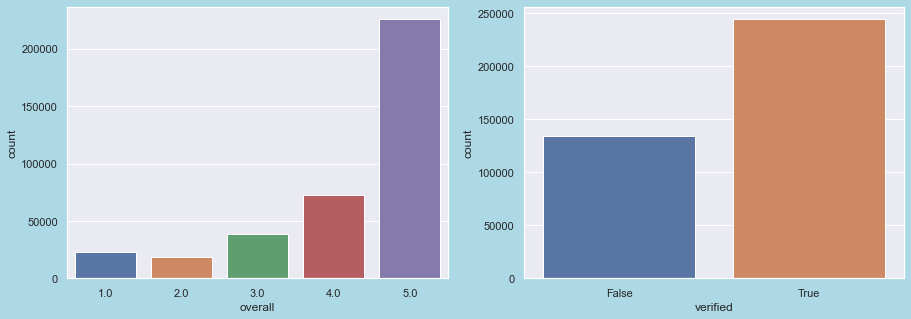

In [16]:
#counts of different ratings and counts of verified/not
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(data=data,x="overall")
plt.subplot(122)
sns.countplot(data=data,x="verified")

<AxesSubplot:xlabel='verified', ylabel='overall'>

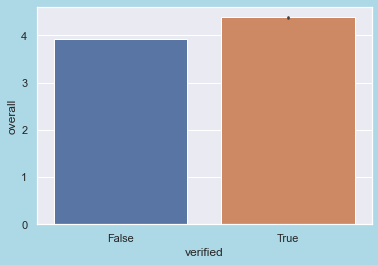

In [17]:
#average rating of verified reviews vs not verified reviews
sns.barplot(data=data,x="verified",y="overall")

In [18]:
m["rank"].sort_values().values[:100]

array([ 23,  59,  68,  71,  73,  75,  98, 101, 113, 116, 127, 128, 128,
       131, 131, 136, 163, 169, 172, 186, 190, 197, 200, 202, 237, 239,
       240, 248, 249, 314, 316, 319, 329, 334, 343, 348, 355, 356, 378,
       379, 390, 390, 407, 415, 423, 427, 430, 432, 442, 448, 452, 455,
       468, 472, 472, 472, 476, 493, 494, 512, 515, 519, 522, 522, 523,
       529, 530, 532, 537, 538, 542, 543, 549, 555, 568, 575, 580, 582,
       585, 588, 591, 596, 596, 597, 598, 601, 617, 620, 633, 651, 660,
       677, 687, 699, 704, 706, 706, 708, 710, 711], dtype=int64)

# Text Classification

In [78]:
#pip install langdetect


  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=37bb0cdd8c7d9d4bf6da946a3f47e01ed9fd9475e5353d70f88419b971d08cef
  Stored in directory: c:\users\aksha\appdata\local\pip\cache\wheels\d1\c1\d9\7e068de779d863bc8f8fc9467d85e25cfe47fa5051fff1a1bb
Successfully built langdetect


In [80]:
data=pd.read_csv("data.csv")
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,category,brand,rank,platform
0,5.0,True,2015-10-17,A1HP7NVNPFMA4N,0700026657,game bit hard get hang great,great,Games,ubisoft,30230,PC
1,4.0,False,2015-07-27,A1JGAP0185YJI6,0700026657,played alright steam bit trouble move game ste...,spite fun liked,Games,ubisoft,30230,PC
2,3.0,True,2015-02-23,A1YJWEXHQBWK2B,0700026657,ok game,three stars,Games,ubisoft,30230,PC
3,2.0,True,2015-02-20,A2204E1TH211HT,0700026657,found game bit complicated expected played,two stars,Games,ubisoft,30230,PC
4,5.0,True,2014-12-25,A2RF5B5H74JLPE,0700026657,great game love played since arrived,love game,Games,ubisoft,30230,PC


In [81]:
main_df=data.copy()

In [82]:
detected_languages = []
for i in range(len(main_df)):
    # Get the text from the column
    text = main_df.loc[i, 'reviewText']
    # Detect the language of the text
    lang = detect(text)
    # Append the detected language to the list
    detected_languages.append(lang)

# Add the detected languages to the DataFrame
main_df['detected_language'] = detected_languages

In [83]:
main_df['detected_language'].unique()

array(['da', 'en', 'sl', 'so', 'ro', 'af', 'pl', 'ca', 'cy', 'sk', 'no',
       'pt', 'tl', 'it', 'et', 'nl', 'es', 'fr', 'sw', 'id', 'fi', 'hr',
       'cs', 'sv', 'sq', 'de', 'tr', 'lt', 'lv', 'hu', 'vi'], dtype=object)

In [91]:
main_df[main_df['detected_language']!="en"]

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,category,brand,rank,platform,detected_language
0,5.0,True,2015-10-17,A1HP7NVNPFMA4N,0700026657,game bit hard get hang great,great,Games,ubisoft,30230,PC,da
2,3.0,True,2015-02-23,A1YJWEXHQBWK2B,0700026657,ok game,three stars,Games,ubisoft,30230,PC,sl
41,5.0,True,2016-07-21,A1PIMVPZAD6X4V,0700099867,good game,great,Games,dirt 3,50093,PC,so
42,4.0,True,2016-06-08,A2G4EXGCH5PQN3,0700099867,good,four stars,Games,dirt 3,50093,PC,so
46,4.0,True,2015-01-31,A2RGUDIF7VB7JZ,0700026398,good game,four stars,Games,square enix,58163,PC,so
...,...,...,...,...,...,...,...,...,...,...,...,...
378124,4.0,True,2017-09-02,A2X90RWVRPOM7I,B01ENWIVE2,telltale walking dead else say,four stars,Games,telltale games,60552,PlayStation,af
378129,5.0,True,2016-06-05,A27Z9KXX61EKR2,B01ENWIVE2,great game big fan telltale,great game big fan telltale,Games,telltale games,60552,PlayStation,da
378130,5.0,True,2017-11-29,A31RO7D1UCJHCZ,B01FIMXX8K,nice item,five stars,Games,"idea factory, inc.",35610,PC,ro
378133,5.0,True,2017-03-26,A2KCNF0QUEEUMM,B01FIMXX8K,fun weeb game,five stars,Games,"idea factory, inc.",35610,PC,cy


In [ ]:
#main_df[main_df['detected_language']!="en"].to_csv("lang.csv")

In [19]:
x=[i for i in data["reviewText"]]

In [20]:
y=data["overall"].values

In [21]:
len(y),len(x)

(378140, 378140)

In [22]:
#!pip install googletrans

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state = 12)

In [29]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', MultinomialNB())
])
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]
}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=2, n_jobs=2, verbose=3)
grid_search_tune.fit(x_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('clf', MultinomialNB())]),
             n_jobs=2,
             param_grid={'tfidf__max_df': (0.25, 0.5, 0.75),
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             verbose=3)

In [30]:
grid_search_tune.best_params_

{'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 1)}

In [31]:
#vectorizing
vector = TfidfVectorizer(stop_words='english',max_df=0.5)
x_train = vector.fit_transform(x_train)
x_test=vector.transform(x_test)

In [32]:
#building classification model
classifier=MultinomialNB()
classifier.fit(x_train, y_train)
y_pred=classifier.predict(x_test)

In [33]:
#classification report of our classifier
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.92      0.02      0.04      4487
         2.0       0.00      0.00      0.00      3666
         3.0       0.48      0.01      0.01      7669
         4.0       0.32      0.03      0.05     14479
         5.0       0.61      1.00      0.76     45327

    accuracy                           0.60     75628
   macro avg       0.46      0.21      0.17     75628
weighted avg       0.53      0.60      0.47     75628



In [36]:
#building classifier model using logistic regression and one vs rest
lr = LogisticRegression(max_iter=200, verbose=1)
ovr = OneVsRestClassifier(lr)

In [37]:
ovr.fit(x_train, y_train)
y_pred = ovr.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.0s finished


In [38]:
#classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         1.0       0.60      0.53      0.56      4487
         2.0       0.38      0.09      0.14      3666
         3.0       0.43      0.22      0.29      7669
         4.0       0.44      0.25      0.32     14479
         5.0       0.73      0.94      0.82     45327

    accuracy                           0.67     75628
   macro avg       0.52      0.41      0.43     75628
weighted avg       0.62      0.67      0.62     75628



In [57]:
f1_score(y_test,y_pred,average="weighted")

0.623088330431972

In [41]:
x_train.shape,y_train.shape

((302512, 147309), (302512,))

In [98]:
df1=data[["overall","reviewText"]]

In [104]:
df1["overall"]=df1["overall"].astype("int")

In [107]:
train_df, test_df = train_test_split(df1, test_size=0.2, random_state=13)

In [108]:
#train set
with open('c_train.txt','w+', encoding="utf-8") as train_file:
    for i in train_df.index:
        labels=""
        labels=labels+'__label__'+str(train_df["overall"][i])
        line = labels + ' '+train_df['reviewText'][i]
        train_file.write(line+'\n')

In [109]:
#test dataset into proper format for fasttext model
with open('c_test.txt','w+', encoding="utf-8") as test_file:
    for i in test_df.index:
        labels=""
        labels=labels+'__label__'+str(test_df["overall"][i])
        line = labels + ' '+test_df['reviewText'][i]
        test_file.write(line+'\n')

In [110]:
t = time()
model_sup = fasttext.train_supervised(input='c_train.txt', lr=0.7, epoch=30, wordNgrams=3, bucket=20000)
training_time = time() - t

In [111]:
training_time

211.55568718910217

In [112]:

# Save the model to a file
model_sup.save_model("model.bin")

In [51]:
#testing the model on test text and printing the f1 score
test_num, precision, recall = model_sup.test('c_test.txt', k=2, threshold=0.4)
f_score = (2*precision*recall)/(precision+recall)
print(f_score)

0.6401180518827577


In [52]:
#testing the model with various values of k and threshold
check = []
list1 = []
list2 = []
for k in np.arange(1,10,1):
    for t in np.arange(0.1,1,0.1):
        test_num, precision, recall = model_sup.test('c_test.txt', k=k, threshold=t)
        f_score = (2*precision*recall)/(precision+recall)
        check.append(f_score)
        list1.append(k) 
        list2.append(t)
mydf = pd.DataFrame([list1,list2,check]).transpose()
mydf.columns = ['K Value','Threshold value','f_score']
mydf.sort_values('f_score',ascending=False)

,K Value,Threshold value,f_score
65,8.0,0.3,0.641493
74,9.0,0.3,0.641493
20,3.0,0.3,0.641493
56,7.0,0.3,0.641493
29,4.0,0.3,0.641493
...,...,...,...
53,6.0,0.9,0.439407
62,7.0,0.9,0.439407
44,5.0,0.9,0.439407
17,2.0,0.9,0.439407


In [113]:
# Read the input data from the file
with open("c_test.txt", "r") as f:
    input_data = [line.strip() for line in f]

# Get the predicted labels for the input data
predictions = model_sup.predict(input_data)

In [114]:
predictions

([['__label__5'],
  ['__label__5'],
  ['__label__1'],
  ['__label__5'],
  ['__label__2'],
  ['__label__5'],
  ['__label__3'],
  ['__label__5'],
  ['__label__5'],
  ['__label__5'],
  ['__label__4'],
  ['__label__2'],
  ['__label__4'],
  ['__label__5'],
  ['__label__5'],
  ['__label__3'],
  ['__label__5'],
  ['__label__5'],
  ['__label__4'],
  ['__label__5'],
  ['__label__5'],
  ['__label__5'],
  ['__label__5'],
  ['__label__4'],
  ['__label__4'],
  ['__label__4'],
  ['__label__5'],
  ['__label__2'],
  ['__label__5'],
  ['__label__5'],
  ['__label__5'],
  ['__label__5'],
  ['__label__3'],
  ['__label__5'],
  ['__label__5'],
  ['__label__5'],
  ['__label__5'],
  ['__label__5'],
  ['__label__5'],
  ['__label__5'],
  ['__label__5'],
  ['__label__4'],
  ['__label__5'],
  ['__label__4'],
  ['__label__5'],
  ['__label__5'],
  ['__label__2'],
  ['__label__5'],
  ['__label__3'],
  ['__label__5'],
  ['__label__1'],
  ['__label__5'],
  ['__label__5'],
  ['__label__5'],
  ['__label__4'],
  ['__labe

In [115]:
model_sup.predict("worst game waste of money")

(('__label__1',), array([1.00001001]))

In [116]:
model_sup.predict("Nice game enjoy")

(('__label__5',), array([0.8323698]))

In [117]:
model_sup.predict("ok timepass")

(('__label__3',), array([0.97672814]))

### Vader Sentiment Analysis

In [422]:
#nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aksha\AppData\Roaming\nltk_data...


True

In [3]:
data=pd.read_csv("data.csv")

In [4]:
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,category,brand,rank,platform
0,5.0,True,2015-10-17,A1HP7NVNPFMA4N,0700026657,game bit hard get hang great,great,Games,ubisoft,30230,PC
1,4.0,False,2015-07-27,A1JGAP0185YJI6,0700026657,played alright steam bit trouble move game ste...,spite fun liked,Games,ubisoft,30230,PC
2,3.0,True,2015-02-23,A1YJWEXHQBWK2B,0700026657,ok game,three stars,Games,ubisoft,30230,PC
3,2.0,True,2015-02-20,A2204E1TH211HT,0700026657,found game bit complicated expected played,two stars,Games,ubisoft,30230,PC
4,5.0,True,2014-12-25,A2RF5B5H74JLPE,0700026657,great game love played since arrived,love game,Games,ubisoft,30230,PC


In [460]:
#data=data.iloc[:100,:]

In [5]:
# Getting the polarity of reviewText 
res2 = {}
t = 0
for i, row in tqdm(data.iterrows(), total=len(data)):
    text = row['reviewText']
    res2[t] = SentimentIntensityAnalyzer().polarity_scores(text)
    t = t + 1

  0%|          | 0/378140 [00:00<?, ?it/s]

In [476]:
# # Getting the polarity of reviewText 
# res2 = {}
# t = 0
# for i, row in tqdm(data.iterrows(), total=len(data)):
#     text = row['reviewText']
#     res2[t] = SentimentIntensityAnalyzer().polarity_scores(text)
#     t = t + 1

  0%|          | 0/378140 [00:00<?, ?it/s]

In [6]:
#Transposing the dataframe .res2 is a dictionary
j = pd.DataFrame(res2).T

In [7]:
# concating the main data and the Polarity Scores
data = pd.concat([data, j], axis = 1)

In [8]:
data.insert(0, 'Class', np.nan)
data.loc[data['compound']>=0.05, 'Class'] = 'pos'
data.loc[data['compound']<=-0.05, 'Class'] = 'neg'
data.loc[((data['compound'] > -0.05) & (data['compound'] < 0.05)), 'Class'] = 'neutral'

In [484]:
data[data["Class"]=="neutral"][["reviewText"]].values[0:5]

array([['still figured one everything instructed game never installed strange since like rate something get work say like get work p manage get installed sure great game first dirt scream bad one bombed maybe bad disc'],
       ['really step dirt better graphics cars seem little responsive overall worth almost money course wait till games old hat buy cheaper really bad thing buy tracks cars nope never going think crappy deal life known lack tracks cars would passed real reason finish game without paying bunch money get extras game begin'],
       ['didnt work xbox one rockband sure blame obama'],
       ['awful controller tamborine slaps rock band register went official mic things much better'],
       ['got use rockband ps4 works']], dtype=object)

In [10]:
data.head(2)

,Class,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,category,brand,rank,platform,neg,neu,pos,compound
0,pos,5.0,True,2015-10-17,A1HP7NVNPFMA4N,0700026657,game bit hard get hang great,great,Games,ubisoft,30230,PC,0.147,0.421,0.432,0.5719
1,pos,4.0,False,2015-07-27,A1JGAP0185YJI6,0700026657,played alright steam bit trouble move game ste...,spite fun liked,Games,ubisoft,30230,PC,0.197,0.368,0.435,0.7947


In [12]:
#data.to_csv("sentiment.csv")

In [480]:
data["overall"].value_counts()

5.0    225537
4.0     72708
3.0     38397
1.0     22967
2.0     18531
Name: overall, dtype: int64

In [481]:
data["Class"].value_counts()

pos        323223
neg         35944
neutral     18973
Name: Class, dtype: int64

### Topic modelling

In [82]:
# # Parameters tuning using Grid Search
# from sklearn.model_selection import GridSearchCV
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.manifold import TSNE
# grid_params = {'n_components' : list(range(5,10))}
# # LDA model
# lda = LatentDirichletAllocation()
# lda_model = GridSearchCV(lda,param_grid=grid_params)
# lda_model.fit(document_term_matrix)
# # Estimators for LDA model
# lda_model1 = lda_model.best_estimator_
# print("Best LDA model's params" , lda_model.best_params_)
# print("Best log likelihood Score for the LDA model",lda_model.best_score_)
# print("LDA model Perplexity on train data", lda_model1.perplexity(document_term_matrix))

### verified /not text classification

In [93]:
data=pd.read_csv("data.csv")
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,category,brand,rank,platform
0,5.0,True,2015-10-17,A1HP7NVNPFMA4N,0700026657,game bit hard get hang great,great,Games,ubisoft,30230,PC
1,4.0,False,2015-07-27,A1JGAP0185YJI6,0700026657,played alright steam bit trouble move game ste...,spite fun liked,Games,ubisoft,30230,PC
2,3.0,True,2015-02-23,A1YJWEXHQBWK2B,0700026657,ok game,three stars,Games,ubisoft,30230,PC
3,2.0,True,2015-02-20,A2204E1TH211HT,0700026657,found game bit complicated expected played,two stars,Games,ubisoft,30230,PC
4,5.0,True,2014-12-25,A2RF5B5H74JLPE,0700026657,great game love played since arrived,love game,Games,ubisoft,30230,PC


In [94]:
x=[i for i in data["reviewText"]]
y=data["overall"].values
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state = 12)

In [95]:
#vectorizing
vector = TfidfVectorizer(stop_words='english')
x_train = vector.fit_transform(x_train)
x_test=vector.transform(x_test)

In [96]:
#building classifier model using logistic regression and one vs rest
lr = LogisticRegression(max_iter=200, verbose=1)
ovr = OneVsRestClassifier(lr)
ovr.fit(x_train, y_train)
y_pred = ovr.predict(x_test)
#classification report
print(classification_report(y_test,y_pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.7s finished


              precision    recall  f1-score   support

         1.0       0.60      0.53      0.56      4487
         2.0       0.38      0.09      0.14      3666
         3.0       0.43      0.22      0.29      7669
         4.0       0.44      0.25      0.32     14479
         5.0       0.73      0.94      0.82     45327

    accuracy                           0.67     75628
   macro avg       0.52      0.41      0.43     75628
weighted avg       0.62      0.67      0.62     75628



### Bigram

In [468]:
neg=data[data["Class"] == "neg"]["reviewText"]
pos=data[data["Class"] == "pos"]["reviewText"]
neu=data[data["Class"] == "neutral"]["reviewText"]

In [473]:
# Getting BIGRAM
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2),stop_words='english').fit(corpus)   # converting a text documents to a matrix of token counts.      
    bag_of_words = vec.transform(corpus)                                         # Transforming the corpus into numbers
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]     # it provides a dictionary with the mapping of the word item index 
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

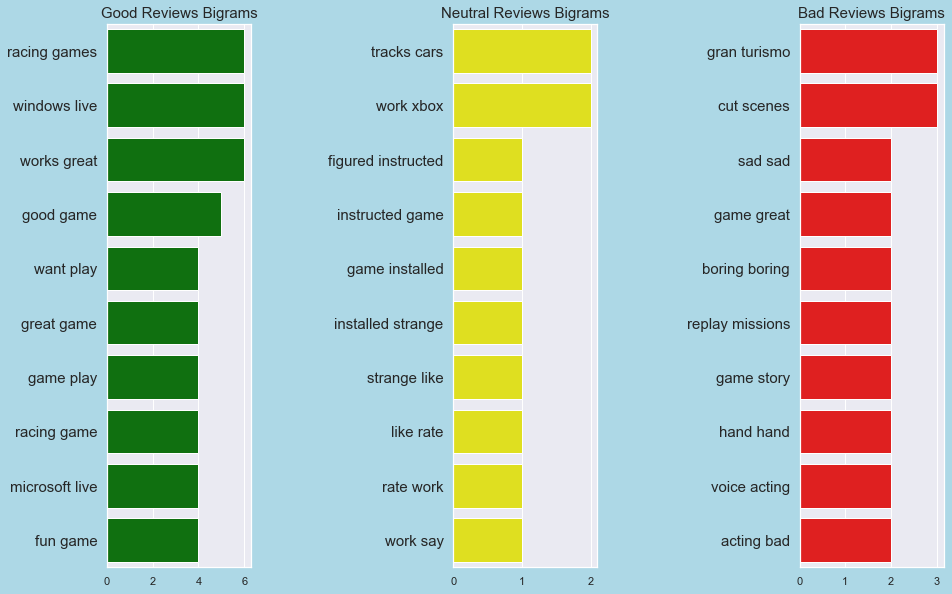

In [474]:
# create a function for bigram plots
def n_gram_plot(data,title,color):                            # Creating n_gram_plot function
    x=[x[0] for x in data]
    y=[x[1] for x in data]
    sns.barplot(y,x,color='{}'.format(color))
    plt.title('{} Reviews Bigrams'.format(title),fontsize=15)
    plt.yticks(rotation=0,fontsize=15)

common_words_good = get_top_n_bigram(pos, 10)                  # Calling get_top_n_bigram for pos columns
common_words_neutral = get_top_n_bigram(neu, 10)               # Calling get_top_n_bigram for neu columns
common_words_bad = get_top_n_bigram(neg, 10)                   # Calling get_top_n_bigram for neg columns

# bigram plot using function above
plt.figure(figsize=(15,10))
# good reviews bigrams
plt.subplot(151)
n_gram_plot(common_words_good,'Good','green')                  # Calling n_gram_plot for pos 
#============================================= 
#neutral reviews bigrams
plt.subplot(153)
n_gram_plot(common_words_neutral,'Neutral','yellow')           # Calling n_gram_plot for pos
#============================================= 
#bad reviews bigrams
plt.subplot(155)
n_gram_plot(common_words_bad,'Bad','red')                      # Calling n_gram_plot for pos
plt.show()

### Product segmentation

In [634]:
#loading rating data
r1=pd.read_csv(r"C:\Users\aksha\Downloads\Video_Games.csv",names=['item','user','rating','timestamp'])
r1.head()

,item,user,rating,timestamp
0,0439381673,A21ROB4YDOZA5P,1.0,1402272000
1,0439381673,A3TNZ2Q5E7HTHD,3.0,1399680000
2,0439381673,A1OKRM3QFEATQO,4.0,1391731200
3,0439381673,A2XO1JFCNEYV3T,1.0,1391731200
4,0439381673,A19WLPIRHD15TH,4.0,1389830400


In [635]:
r1.head(5)

,item,user,rating,timestamp
0,0439381673,A21ROB4YDOZA5P,1.0,1402272000
1,0439381673,A3TNZ2Q5E7HTHD,3.0,1399680000
2,0439381673,A1OKRM3QFEATQO,4.0,1391731200
3,0439381673,A2XO1JFCNEYV3T,1.0,1391731200
4,0439381673,A19WLPIRHD15TH,4.0,1389830400


In [636]:
r=r1.groupby("item").agg({"rating":"mean","item":"size"}).rename(columns={"rating":"average_rating","item":"total_sold"})
r.head()

,average_rating,total_sold
item,,
0042000742,5.00,1
0078764343,4.75,4
0276425316,5.00,1
0324411812,1.00,1
0439335299,3.00,1


In [637]:
i=r.index

<AxesSubplot:xlabel='average_rating', ylabel='Count'>

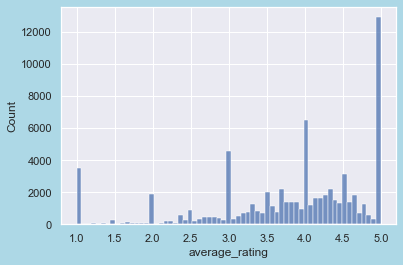

In [107]:
sns.histplot(data=r,x="average_rating")

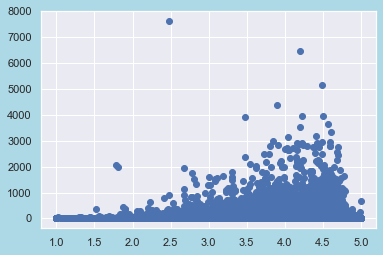

In [91]:
plt.scatter(r["average_rating"],r["total_sold"])

In [622]:
#scaler=MinMaxScaler()
scaler=StandardScaler()
r=pd.DataFrame(scaler.fit_transform(r),columns=r.columns)

{2: 0.5261409683543034,
 3: 0.5594178108242966,
 4: 0.5752021637056819,
 5: 0.5121496553456016,
 6: 0.5322379568570552,
 7: 0.5339953285814543,
 8: 0.5465673139442889,
 9: 0.5525037256966802}

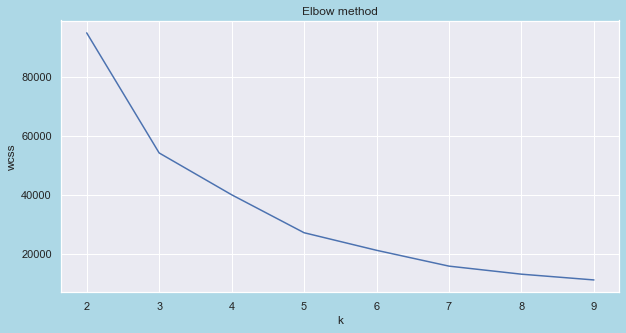

In [171]:
wcss=[]
silhoutte={}
for k in range(2,10):
    c=KMeans(n_clusters=k).fit(r)
    labels=c.labels_
    wcss.append(c.inertia_)
    silhoutte[k]=silhouette_score(r,labels)
plt.figure(figsize=(10,5))
plt.plot(range(2,10),wcss)
plt.title("Elbow method")
plt.xlabel("k")
plt.ylabel("wcss")
silhoutte

In [97]:
#choosing k as 3 from elbow method and silhoeutte score is good

In [623]:
cluster=KMeans(n_clusters=3).fit(r)

In [624]:
labels=cluster.labels_

In [625]:
labels

array([0, 0, 0, ..., 0, 0, 0])

In [638]:
i

Index(['0042000742', '0078764343', '0276425316', '0324411812', '0439335299',
       '0439335310', '043933702X', '0439339006', '0439339960', '0439339987',
       ...
       'B01HIZF83S', 'B01HIZGKOE', 'B01HJ13III', 'B01HJ149LI', 'B01HJ14FDA',
       'B01HJ14OT0', 'B01HJ14TTA', 'B01HJ1521Y', 'B01HJC33WS', 'B01HJEBIAA'],
      dtype='object', name='item', length=71982)

In [659]:
label=pd.DataFrame({"asin":i,'cluster':labels})

In [660]:
label

,asin,cluster
0,0042000742,0
1,0078764343,0
2,0276425316,0
3,0324411812,1
4,0439335299,1
...,...,...
71977,B01HJ14OT0,0
71978,B01HJ14TTA,1
71979,B01HJ1521Y,0
71980,B01HJC33WS,0


In [661]:
label.to_csv("label.csv",index=False)

In [633]:
np.unique(labels,return_counts=True)

(array([0, 1, 2]), array([51827, 19473,   682], dtype=int64))

<AxesSubplot:xlabel='average_rating', ylabel='total_sold'>

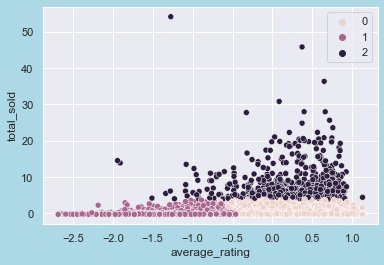

In [626]:
sns.scatterplot(data=r,x="average_rating",y="total_sold",hue=labels)

In [ ]:
# agglomerative hierarchical clustering

In [597]:
#loading rating data
r1=pd.read_csv(r"C:\Users\aksha\Downloads\Video_Games.csv",names=['item','user','rating','timestamp'])
r1.head()

,item,user,rating,timestamp
0,0439381673,A21ROB4YDOZA5P,1.0,1402272000
1,0439381673,A3TNZ2Q5E7HTHD,3.0,1399680000
2,0439381673,A1OKRM3QFEATQO,4.0,1391731200
3,0439381673,A2XO1JFCNEYV3T,1.0,1391731200
4,0439381673,A19WLPIRHD15TH,4.0,1389830400


In [598]:
r=r1.groupby("item").agg({"rating":"mean","item":"size"}).rename(columns={"rating":"average_rating","item":"total_sold"})
r.head()

,average_rating,total_sold
item,,
0042000742,5.00,1
0078764343,4.75,4
0276425316,5.00,1
0324411812,1.00,1
0439335299,3.00,1


In [599]:
scaler=StandardScaler()
r=pd.DataFrame(scaler.fit_transform(r),columns=r.columns)

In [600]:
r.head()

,average_rating,total_sold
0,1.129739,-0.247049
1,0.891318,-0.225652
2,1.129739,-0.247049
3,-2.684993,-0.247049
4,-0.777627,-0.247049


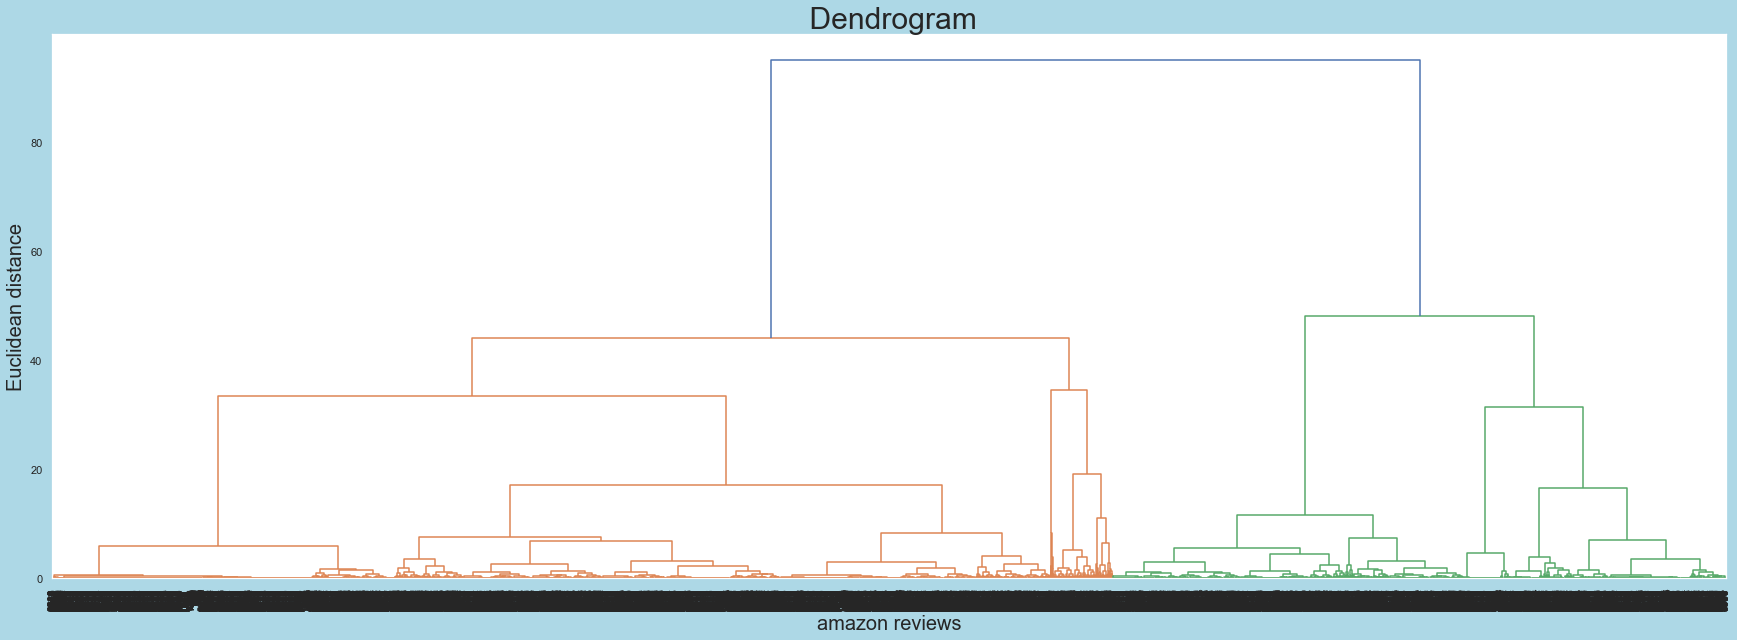

In [606]:
plt.figure(figsize=(30, 10))
dendrogrm = sch.dendrogram(sch.linkage(r, method = 'ward'))
ax = plt.gca()
#plt.axhline(y=15, color='r', linestyle='--')
ax.tick_params(axis='x', which='major', labelsize=10)
plt.title(' Dendrogram',fontsize=30)
plt.xlabel('amazon reviews',fontsize=20)
plt.ylabel('Euclidean distance', fontsize=20)
plt.show()

In [617]:
model=AgglomerativeClustering(n_clusters=4).fit(r)
labels=model.labels_
s=silhouette_score(r,labels)
print("silhouette score:",s)

silhouette score: 0.4341387862118916


### Customer Segmentation

In [50]:
#loading rating data
r1=pd.read_csv(r"C:\Users\aksha\Downloads\Video_Games.csv",names=['item','user','rating','timestamp'])
r1.head()

,item,user,rating,timestamp
0,0439381673,A21ROB4YDOZA5P,1.0,1402272000
1,0439381673,A3TNZ2Q5E7HTHD,3.0,1399680000
2,0439381673,A1OKRM3QFEATQO,4.0,1391731200
3,0439381673,A2XO1JFCNEYV3T,1.0,1391731200
4,0439381673,A19WLPIRHD15TH,4.0,1389830400


In [51]:
# Convert the timestamp to a datetime object
for i,j in r1.iterrows():
    t=j["timestamp"]
    dt = datetime.fromtimestamp(t)
    r1.at[i,"timestamp"]=dt.strftime("%Y-%m-%d")

In [52]:
r1["timestamp"]=pd.to_datetime(r1["timestamp"])

In [53]:
a=r1.groupby('user')["timestamp"].max().reset_index()
a["recency"]=(a['timestamp'].max() - a['timestamp']).dt.days
a.head()

,user,timestamp,recency
0,A0002090WKEMAO8KOWKM,2014-12-03,1399
1,A0003214FKMKJE0PCW3D,2014-10-29,1434
2,A0003492LQH8LJXPWDMZ,2018-04-27,158
3,A0005622E33Y7RCVKKVN,2015-10-19,1079
4,A00065507CNSR8UHQFCK,2013-01-08,2093


In [54]:
l=a["recency"].tolist()

In [55]:
b=r1.groupby("user").agg({"rating":"mean","item":"size"}).rename(columns={"rating":"satisfaction","item":"frequency"})
b.head()

,satisfaction,frequency
user,,
A0002090WKEMAO8KOWKM,5.0,2
A0003214FKMKJE0PCW3D,5.0,1
A0003492LQH8LJXPWDMZ,3.0,1
A0005622E33Y7RCVKKVN,5.0,3
A00065507CNSR8UHQFCK,4.0,2


In [56]:
b["recency"]=l

In [57]:
b.head()

,satisfaction,frequency,recency
user,,,
A0002090WKEMAO8KOWKM,5.0,2,1399
A0003214FKMKJE0PCW3D,5.0,1,1434
A0003492LQH8LJXPWDMZ,3.0,1,158
A0005622E33Y7RCVKKVN,5.0,3,1079
A00065507CNSR8UHQFCK,4.0,2,2093


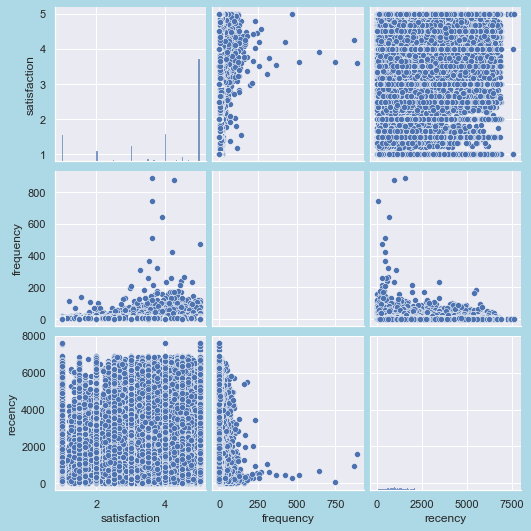

In [389]:
sns.pairplot(b)

In [58]:
scaler=StandardScaler()
b=pd.DataFrame(scaler.fit_transform(b),columns=b.columns)

Text(0, 0.5, 'wcss')

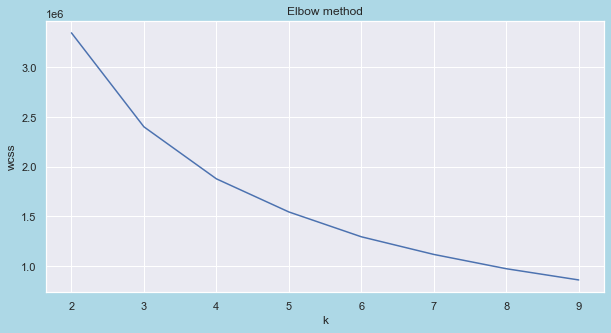

In [392]:
wcss=[]
#silhoutte={}
for k in range(2,10):
    m=KMeans(n_clusters=k).fit(b)
    labels=m.labels_
    wcss.append(m.inertia_)
    #silhoutte[k]=silhouette_score(c,labels)
plt.figure(figsize=(10,5))
plt.plot(range(2,10),wcss)
plt.title("Elbow method")
plt.xlabel("k")
plt.ylabel("wcss")
#silhoutte

In [59]:
m=KMeans(n_clusters=3).fit(b)
labels=m.labels_

In [394]:
silhouette_score(b.iloc[:10000,],labels[:10000])

0.5187754101335268

In [60]:
b["labels"]=labels

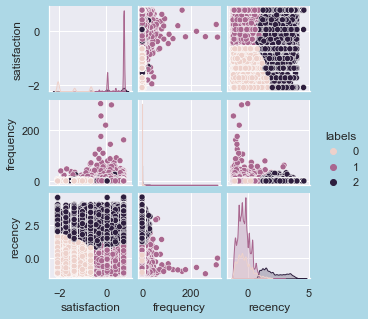

In [66]:
sns.pairplot(b,hue='labels',height=1.5)

In [71]:
b.drop('labels',inplace=True,axis=1)

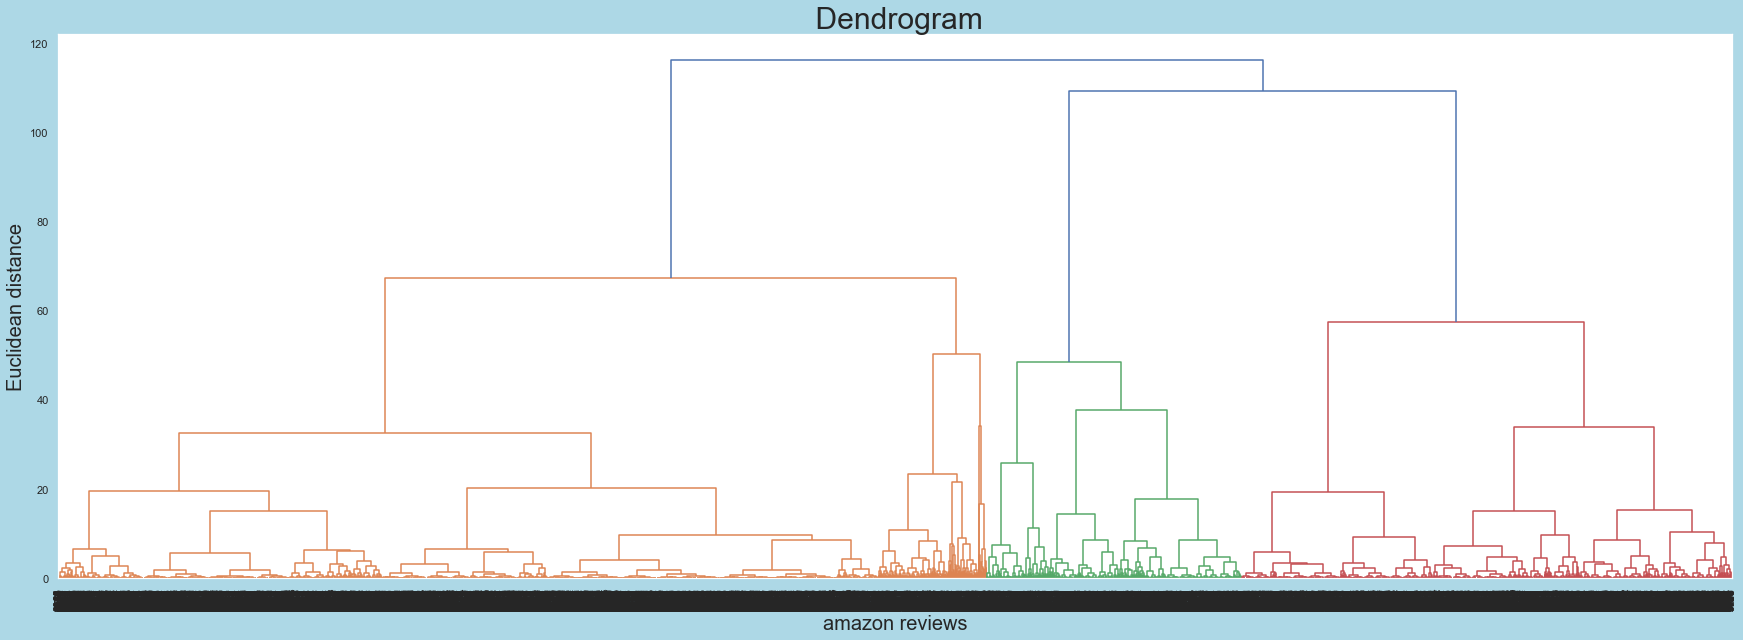

In [73]:
#agglomerative hierarchical clustering
plt.figure(figsize=(30, 10))
dendrogrm = sch.dendrogram(sch.linkage(b, method = 'ward'))
ax = plt.gca()
#plt.axhline(y=15, color='r', linestyle='--')
ax.tick_params(axis='x', which='major', labelsize=10)
plt.title(' Dendrogram',fontsize=30)
plt.xlabel('amazon reviews',fontsize=20)
plt.ylabel('Euclidean distance', fontsize=20)
plt.show()

In [76]:
model=AgglomerativeClustering(n_clusters=3).fit(b)
labels=model.labels_
s=silhouette_score(b,labels)
print("silhouette score:",s)

silhouette score: 0.41560217567802454


### item-item colloborative filtering

In [107]:
#loading rating data
r2=pd.read_csv(r"C:\Users\aksha\Downloads\Video_Games.csv",names=['item','user','rating','timestamp'])
r2.head()

,item,user,rating,timestamp
0,0439381673,A21ROB4YDOZA5P,1.0,1402272000
1,0439381673,A3TNZ2Q5E7HTHD,3.0,1399680000
2,0439381673,A1OKRM3QFEATQO,4.0,1391731200
3,0439381673,A2XO1JFCNEYV3T,1.0,1391731200
4,0439381673,A19WLPIRHD15TH,4.0,1389830400


In [108]:
r2=r2.drop("timestamp",axis=1)

In [109]:
r2.head()

,item,user,rating
0,0439381673,A21ROB4YDOZA5P,1.0
1,0439381673,A3TNZ2Q5E7HTHD,3.0
2,0439381673,A1OKRM3QFEATQO,4.0
3,0439381673,A2XO1JFCNEYV3T,1.0
4,0439381673,A19WLPIRHD15TH,4.0


In [110]:
r2["user"].nunique()

1540618

In [111]:
r2['item'].nunique()

71982

In [112]:
x=r2.groupby("user").count()["rating"]>10

In [113]:
x=x[x].index

In [114]:
g=r2[r2["user"].isin(x)]

In [115]:
y=g.groupby("item").count()["rating"]>10

In [116]:
y=y[y].index

In [117]:
g=g[g["item"].isin(y)]

In [118]:
g

,item,user,rating
92,0700099867,AN3YYDZAS3O1Y,5.0
97,0700099867,A15PIAQT55GNCA,5.0
98,0700099867,A361M14PU2GUEG,4.0
99,0700099867,A2LQCBLLJVVR5T,5.0
125,0700099867,A248LSBZT4P38V,1.0
...,...,...,...
2563786,B01H2DKHZ0,A1NFDBD9B7360Y,5.0
2563806,B01H2DKHPA,A30T51SMB0UQR1,5.0
2563878,B01H3NU4OS,A28T3GWEMQLXWI,5.0
2563883,B01H3NU4OS,A2Q8SD3EJVRNPQ,5.0


In [119]:
g=g.pivot_table(index="item",columns="user",values="rating",fill_value=0)

In [120]:
g.head()

user,A0266076X6KPZ6CCHGVS,A0380485C177Q6QQNJIX,A0685888WB02Q69S553P,A0695568PX4DBZOQDN8,A08761257GP04TJ0ROBS,A0986665A7J4V94FK3RZ,A100JCBNALJFAW,A100STMN7BADN9,A100U2O7L15XNL,A1027EV8A9PV1O,...,AZXBNJDQTYU8S,AZXHK8IO25FL6,AZXWP83KBEA7N,AZYG5R26NUP70,AZYU8M791SIFC,AZYWRH9CQSB2Q,AZZ1KF8RAO1BR,AZZ3GFL1HTBLY,AZZHLZ8H23QD4,AZZQCK9ZAKMFR
item,,,,,,,,,,,,,,,,,,,,,
0700099867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0804161380,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9625990674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9629971372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9882155456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
sim=cosine_similarity(g)

In [123]:
sim.shape

(5588, 5588)

In [124]:
def rec(item):
    index=np.where(g.index==item)[0][0]
    s=sorted(list(enumerate(sim[index])),key=lambda x:x[1],reverse=True)[1:6]
    for i in s:
        print(g.index[i[0]])

In [125]:
recommend('9882155456')

B0017KIBAI
B00009PS22
B01EU09FB0
B0001JSSLS
B004K6LQ9E


### Video Games Future Demand

In [689]:
data=pd.read_csv("data.csv")
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,category,brand,rank,platform
0,5.0,True,2015-10-17,A1HP7NVNPFMA4N,0700026657,game bit hard get hang great,great,Games,ubisoft,30230,PC
1,4.0,False,2015-07-27,A1JGAP0185YJI6,0700026657,played alright steam bit trouble move game ste...,spite fun liked,Games,ubisoft,30230,PC
2,3.0,True,2015-02-23,A1YJWEXHQBWK2B,0700026657,ok game,three stars,Games,ubisoft,30230,PC
3,2.0,True,2015-02-20,A2204E1TH211HT,0700026657,found game bit complicated expected played,two stars,Games,ubisoft,30230,PC
4,5.0,True,2014-12-25,A2RF5B5H74JLPE,0700026657,great game love played since arrived,love game,Games,ubisoft,30230,PC


In [690]:
data["reviewTime"]=pd.to_datetime(data["reviewTime"])

In [555]:
data.dtypes

overall              float64
verified                bool
reviewTime    datetime64[ns]
reviewerID            object
asin                  object
reviewText            object
summary               object
category              object
brand                 object
rank                   int64
platform              object
dtype: object

In [691]:
t=data.groupby("reviewTime").count()["asin"]
t

reviewTime
1999-10-14    1
1999-11-05    1
1999-11-10    7
1999-11-12    1
1999-11-14    1
             ..
2018-09-27    5
2018-09-28    2
2018-09-30    1
2018-10-01    3
2018-10-02    1
Name: asin, Length: 6844, dtype: int64

In [557]:
data["reviewTime"].min(),data["reviewTime"].max()

(Timestamp('1999-10-14 00:00:00'), Timestamp('2018-10-02 00:00:00'))

In [692]:
t=t.resample("W").sum()
t

reviewTime
1999-10-17     1
1999-10-24     0
1999-10-31     0
1999-11-07     1
1999-11-14     9
              ..
2018-09-09    42
2018-09-16    33
2018-09-23    27
2018-09-30    13
2018-10-07     4
Freq: W-SUN, Name: asin, Length: 991, dtype: int64

In [693]:
t=t.to_frame()
t.head()

,asin
reviewTime,
1999-10-17,1
1999-10-24,0
1999-10-31,0
1999-11-07,1
1999-11-14,9


In [560]:
t.index.is_monotonic_increasing

True

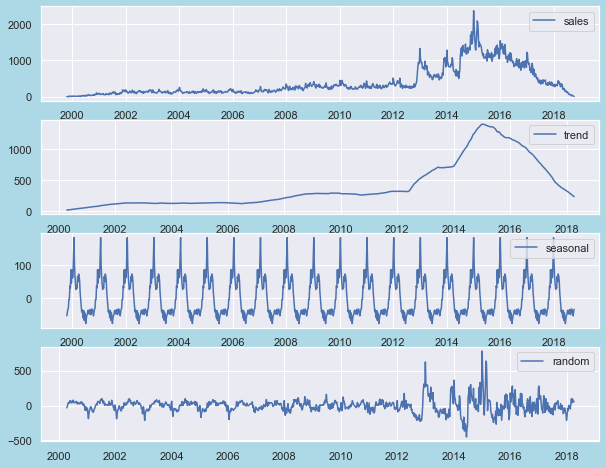

In [561]:
#visualizing the  time series components
decomp=seasonal_decompose(t)
trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid
fig,ax=plt.subplots(4,1,figsize=(10,8))
plt.subplot(411)
plt.plot(t,label="sales")
plt.legend()

plt.subplot(412)
plt.plot(trend,label="trend")
plt.legend()

plt.subplot(413)
plt.plot(seasonal,label="seasonal")
plt.legend()

plt.subplot(414)
plt.plot(residual,label="random")
plt.legend()

In [562]:
# ADF test to determine data stationarity
def checkStationarity(data):
    pvalue = adfuller(data)[1]

    if pvalue < 0.05:
        msg = "pvalue={}. Data is Stationary. Proceed to model building".format(pvalue)
    else:
        msg = "pvalue={}. Data is not Stationary. Make the data stationary before model building".format(pvalue)
    return(msg)

In [563]:
# check if the sales data is stationary
checkStationarity(t)

'pvalue=0.32911762616428974. Data is not Stationary. Make the data stationary before model building'

In [564]:
t1= t - t.shift()
t1.dropna(inplace = True)

In [565]:
print(checkStationarity(t1))

pvalue=7.904476216960257e-11. Data is Stationary. Proceed to model building


In [566]:
# t1=t1-t1.shift()
# t1.dropna(inplace = True)
# print(checkStationarity(t1))

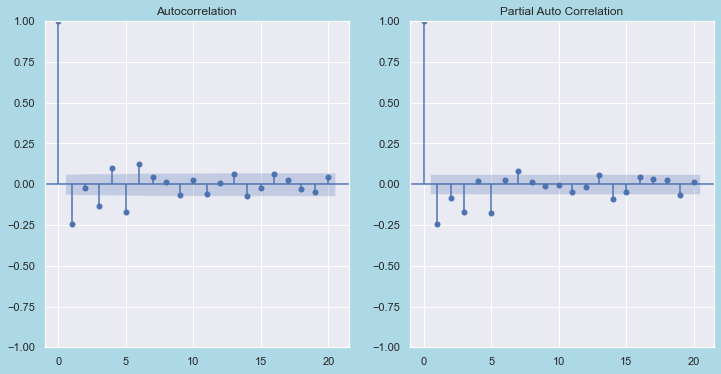

In [567]:
# ACF and PACF plots
ROWS = 1; COLS = 2
fig,ax = plt.subplots(ROWS,COLS,figsize=(12,6))
plot_acf(t1, lags=20, ax=ax[0]);
plt.title("Auto Correlation")

plot_pacf(t1, lags=20, ax=ax[1]);
plt.title("Partial Auto Correlation")

plt.show()

In [694]:
#train test split
sp=int(0.95*len(t))
train=t.iloc[:sp]
test=t.iloc[sp:]

In [695]:
len(train),len(test)

(941, 50)

In [579]:
#appending p and q in list and d is 1 since data is stationary

p=[1,2,3,4,5,6]
q=[1,2,3,4,5]
P=[1,2]
Q=[1,2]
d=1
lis=[]
# building model
model=[]
for i in tqdm(p,total=len(p)):
    for j in q:
        m = sm.tsa.statespace.SARIMAX(train,order=(4,1,3),seasonal_order=(2,1,1,52)).fit() 
        model.append(m)
        lis.append([i,1,j])
# checking model is good or not using ljungbox
c=1
for i in model:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        #print(f'Model {c} Not a good model')
    else:
        #print(f'Model {c} Good model')
    c+=1

In [200]:
# calculating AIC and BIC score   
aic=[]
bic=[]
for i in model[0:]:
    aic.append(i.aic)
    bic.append(i.bic)
# predicting values
forecast=[]
for i in model[0:]:
    fcast = i.predict(start=len(train), end=len(train)+len(test)-1)
    forecast.append(fcast)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast:
    mse = mean_squared_error(test, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)
    
# printing model numbers
model_no=[]
for i in range(0,len(model)):
    model_no.append('Model '+str(i))
    
# dataframe of all results
df_results = pd.DataFrame({'Model No.': model_no, '(P, d, Q)':lis[0:], 'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results.sort_values(["AIC","MSE"])

[2468.3603715329646, 2459.491435571542, 2456.338618322641, 2463.502528284268, 2464.8343525819764, 2469.7112322060057, 2473.374441151539, 2479.2790112027415]


,Model No.,"(P, d, Q)",AIC,BIC,MSE,RMSE
2,Model 2,"[1, 1, 0]",2446.931223,2456.338618,6.769710e+07,8227.824570
5,Model 5,"[2, 1, 1]",2447.760643,2469.711232,5.413248e+07,7357.477994
3,Model 3,"[1, 1, 1]",2447.823536,2463.502528,5.234050e+07,7234.673394
4,Model 4,"[2, 1, 0]",2449.155360,2464.834353,6.897630e+07,8305.197451
1,Model 1,"[0, 1, 1]",2450.084040,2459.491436,7.281585e+07,8533.220550
7,Model 7,"[3, 1, 1]",2451.056825,2479.279011,5.605944e+07,7487.285139
6,Model 6,"[3, 1, 0]",2451.423852,2473.374441,6.898946e+07,8305.989179
0,Model 0,"[0, 1, 0]",2465.224573,2468.360372,1.158122e+08,10761.606604


In [696]:
model = sm.tsa.statespace.SARIMAX(train,order=(4,1,3),seasonal_order=(2,1,1,52)).fit()

In [591]:
#checking aic and bic of our model
aic1,bic1 = np.round(model.aic,2), np.round(model.bic,2)
print("Model 1: AIC={},BIC={}".format(aic1,bic1))

Model 1: AIC=10341.24,BIC=10393.92


In [697]:
#actual ,forecasted and error for sales as forecasted by sarima model
start=len(train)
end=len(test)+len(train)-1
p=model.predict(start,end)
dff2=pd.DataFrame({'actual':test.asin, 'forecasts':p.values})
#finding error actual-forecasted
dff2["error"]=dff2["actual"]-dff2["forecasts"]
dff2.head()

,actual,forecasts,error
reviewTime,,,
2017-10-29,348,317.200935,30.799065
2017-11-05,409,411.335547,-2.335547
2017-11-12,362,400.525655,-38.525655
2017-11-19,331,546.728742,-215.728742
2017-11-26,313,430.108325,-117.108325


In [593]:
# Calcualating the MSE
mse = mean_squared_error(dff2.actual, dff2.forecasts) 
mse

19396.918079719075

In [595]:
pvalue = sm.stats.acorr_ljungbox(model.resid, lags=[1], return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print('Model  is not a good model')
else:
    print('Model is a Good model')

Model is a Good model


Text(0.5, 1.0, 'SARIMA model')

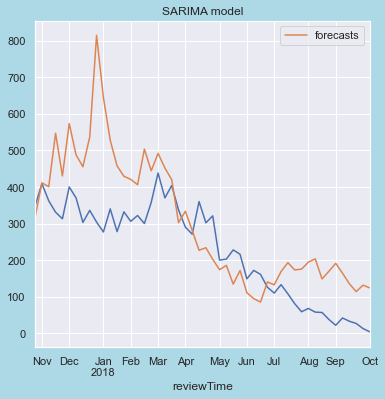

In [584]:
# plotting the actual and forecast data of the test data
dff2.actual.plot(figsize=(6,6))
dff2.forecasts.plot(legend=True)
plt.title("SARIMA model")

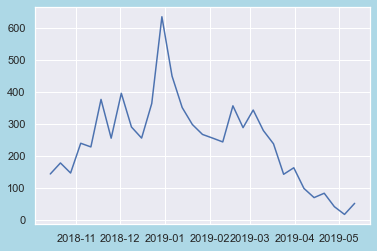

In [700]:
plt.plot(model.predict(len(train)+len(test),len(train)+len(test)+30))

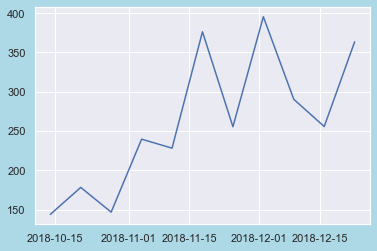

In [585]:
plt.plot(model.predict(len(train)+len(test),len(train)+len(test)+10))

### Product wise

In [290]:
data=pd.read_csv("data.csv")

In [291]:
data["reviewTime"]=pd.to_datetime(data["reviewTime"])

In [292]:
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,category,brand,rank,platform
0,5.0,True,2015-10-17,A1HP7NVNPFMA4N,0700026657,game bit hard get hang great,great,Games,ubisoft,30230,PC
1,4.0,False,2015-07-27,A1JGAP0185YJI6,0700026657,played alright steam bit trouble move game ste...,spite fun liked,Games,ubisoft,30230,PC
2,3.0,True,2015-02-23,A1YJWEXHQBWK2B,0700026657,ok game,three stars,Games,ubisoft,30230,PC
3,2.0,True,2015-02-20,A2204E1TH211HT,0700026657,found game bit complicated expected played,two stars,Games,ubisoft,30230,PC
4,5.0,True,2014-12-25,A2RF5B5H74JLPE,0700026657,great game love played since arrived,love game,Games,ubisoft,30230,PC


In [305]:
data["platform"].value_counts()

PlayStation    142631
Nintendo        96806
XBOX            90042
PC              48401
Mac               260
Name: platform, dtype: int64

In [294]:
pc=data[data['platform']=="PC"]
pc=data.groupby("reviewTime").count()["asin"]
pc=pc.resample("W").sum()
pc.name="pc"

In [303]:
pc.index.is_monotonic

True

In [335]:
#visualizing the  time series components
def ts(i):
    decomp=seasonal_decompose(i)
    trend=decomp.trend
    seasonal=decomp.seasonal
    residual=decomp.resid
    
    fig,ax=plt.subplots(4,1,figsize=(20,12))
    
    plt.subplot(411)
    plt.plot(i,label="sales:"+i.name)
    plt.legend()

    plt.subplot(412)
    plt.plot(trend,label="trend")
    plt.legend()

    plt.subplot(413)
    plt.plot(seasonal,label="seasonal")
    plt.legend()

    plt.subplot(414)
    plt.plot(residual,label="random")
    plt.legend()
    plt.show()

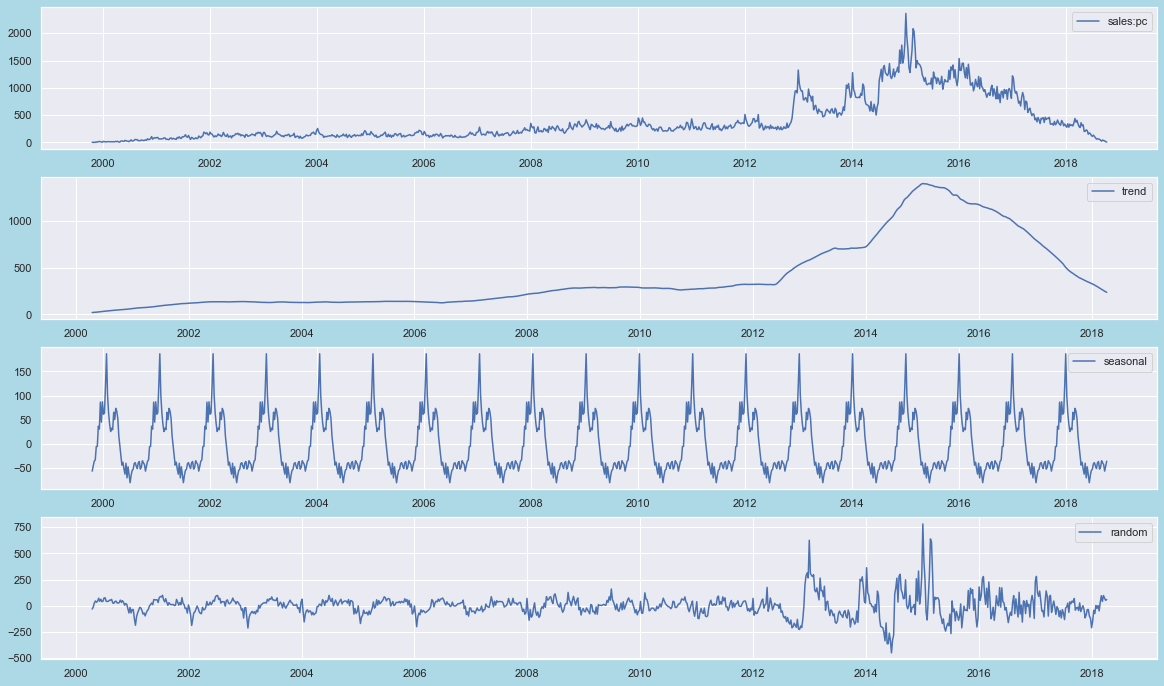

In [336]:
ts(pc)

In [337]:
ps=data[data['platform']=="PlayStation"]
ps=data.groupby("reviewTime").count()["asin"]
ps=ps.resample("W").sum()
ps.name="playstation"
ps.index.is_monotonic

True

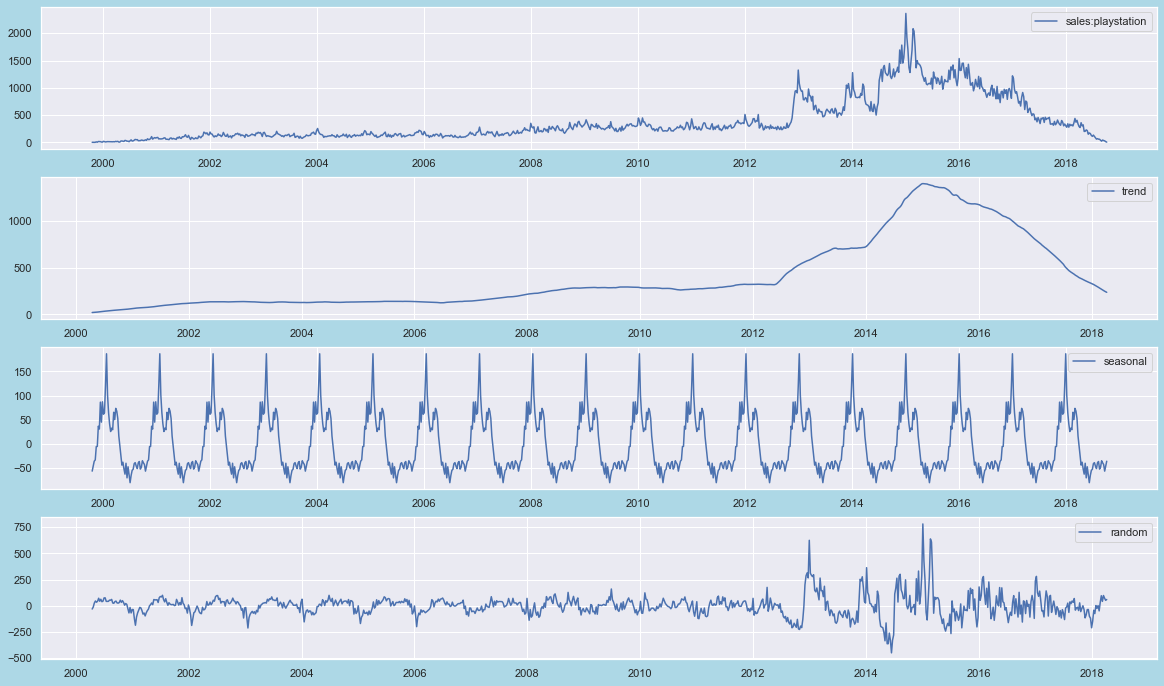

In [338]:
ts(ps)

In [341]:
xb=data[data['platform']=="XBOX"]
xb=data.groupby("reviewTime").count()["asin"]
xb=xb.resample("W").sum()
xb.name="xbox"
xb.index.is_monotonic

True

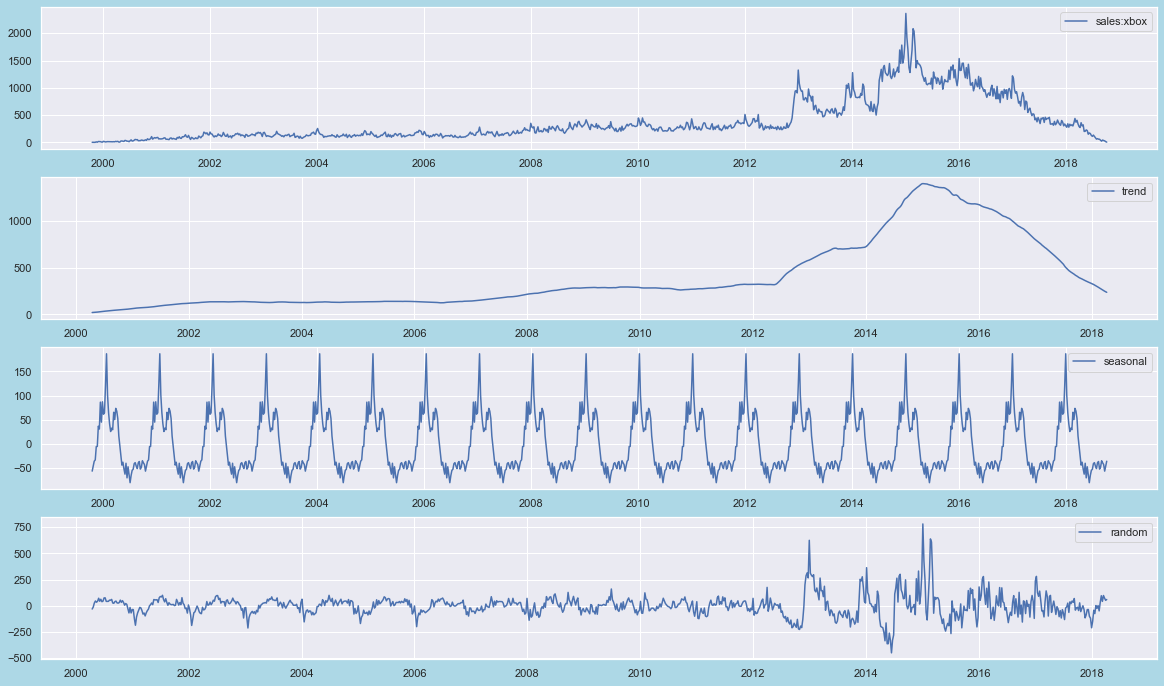

In [342]:
ts(xb)

In [343]:
ntn=data[data['platform']=="Nintendo"]
ntn=data.groupby("reviewTime").count()["asin"]
ntn=ntn.resample("W").sum()
ntn.name="Nintendo"
ntn.index.is_monotonic

True

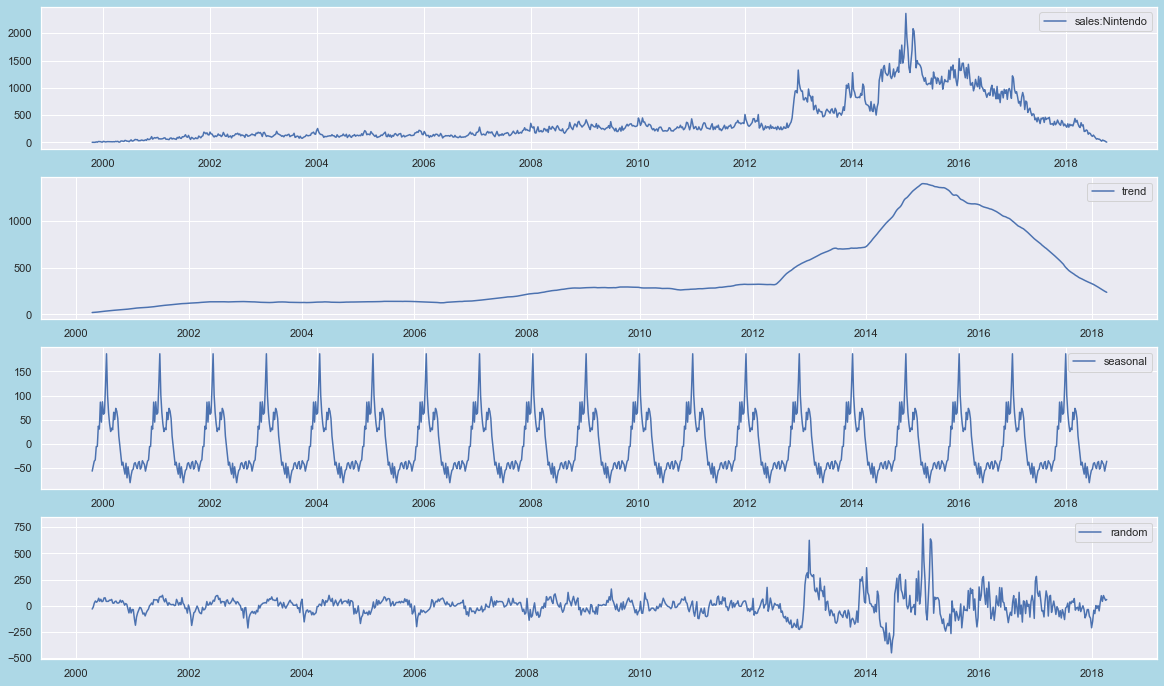

In [345]:
ts(ntn)

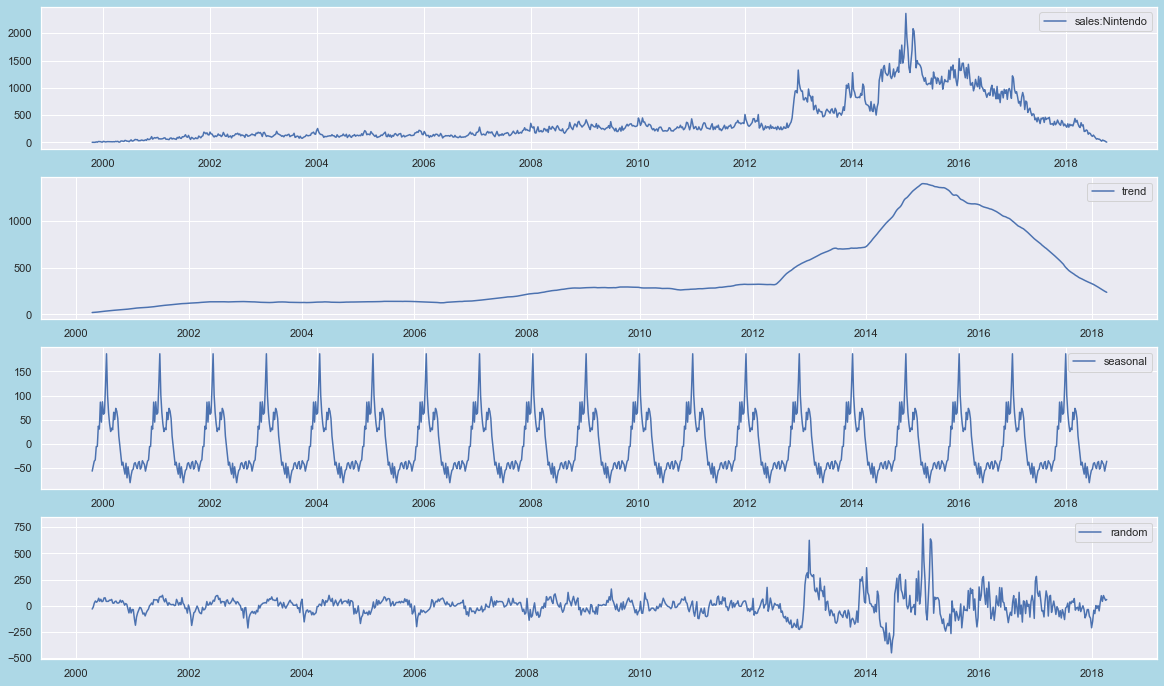

In [350]:
#visualizing the  time series components

decomp=seasonal_decompose(ntn)
trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid

fig,ax=plt.subplots(4,1,figsize=(20,12))

plt.subplot(411)
plt.plot(ntn,label="sales:"+ntn.name)
plt.legend()

plt.subplot(412)
plt.plot(trend,label="trend")
plt.legend()

plt.subplot(413)
plt.plot(seasonal,label="seasonal")
plt.legend()

plt.subplot(414)
plt.plot(residual,label="random")
plt.legend()
plt.show()

In [596]:
#every product has a same time series distribution as a whole data 

### Product cluster 0 demand forecasting

In [27]:
label=pd.read_csv("label.csv")
label.head()

,asin,cluster
0,0042000742,0
1,0078764343,0
2,0276425316,0
3,0324411812,1
4,0439335299,1


In [28]:
df=pd.read_csv("data.csv")

In [29]:
df["reviewTime"]=pd.to_datetime(df["reviewTime"])

In [30]:
df=pd.merge(df,label,on="asin")

In [31]:
df=df[["asin","reviewTime","cluster"]]

In [32]:
df.head()

,asin,reviewTime,cluster
0,0700026657,2015-10-17,1
1,0700026657,2015-07-27,1
2,0700026657,2015-02-23,1
3,0700026657,2015-02-20,1
4,0700026657,2014-12-25,1


In [33]:
df0=df[df["cluster"]==0]

In [34]:
df0=df0.groupby("reviewTime").count()["asin"]
df0=df0.resample("W").sum()
df0=df0.to_frame()
df0.head()

,asin
reviewTime,
1999-11-07,1
1999-11-14,8
1999-11-21,1
1999-11-28,15
1999-12-05,14


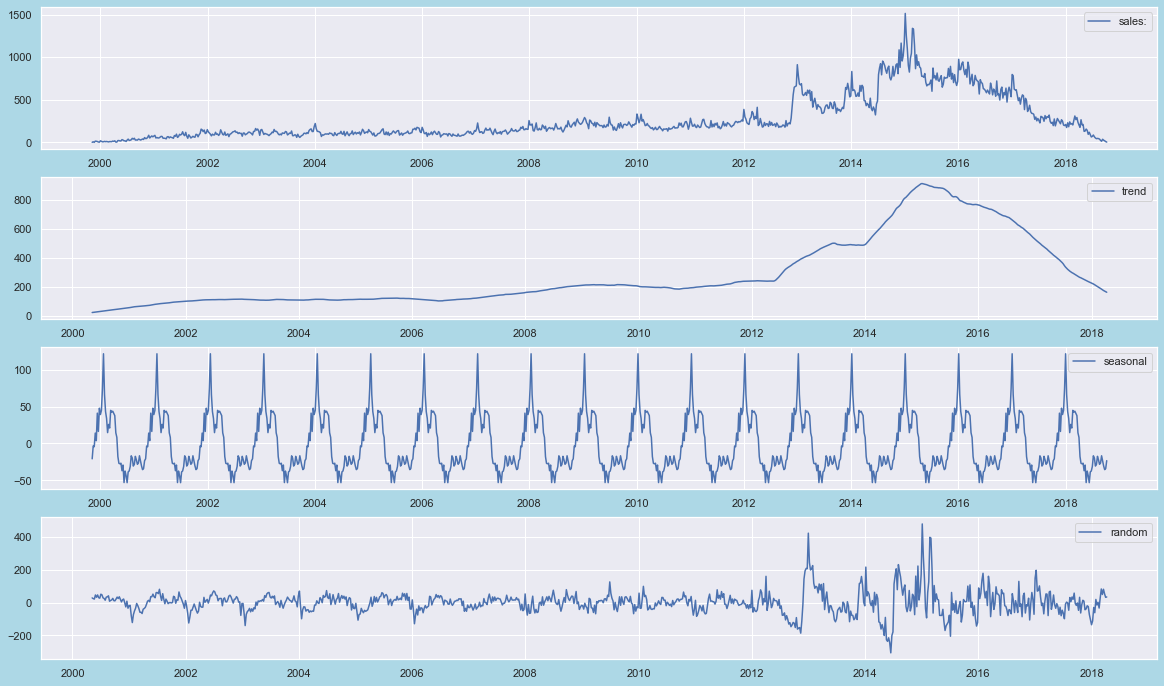

In [35]:
#visualizing the  time series components

decomp=seasonal_decompose(df0)
trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid

fig,ax=plt.subplots(4,1,figsize=(20,12))

plt.subplot(411)
plt.plot(df0,label="sales:")
plt.legend()

plt.subplot(412)
plt.plot(trend,label="trend")
plt.legend()

plt.subplot(413)
plt.plot(seasonal,label="seasonal")
plt.legend()

plt.subplot(414)
plt.plot(residual,label="random")
plt.legend()
plt.show()

In [36]:
# ADF test to determine data stationarity
def checkStationarity(data):
    pvalue = adfuller(data)[1]

    if pvalue < 0.05:
        msg = "pvalue={}. Data is Stationary. Proceed to model building".format(pvalue)
    else:
        msg = "pvalue={}. Data is not Stationary. Make the data stationary before model building".format(pvalue)
    return(msg)

In [37]:
# check if the sales data is stationary
checkStationarity(df0)

'pvalue=0.44204591313325503. Data is not Stationary. Make the data stationary before model building'

In [38]:
d=df0-df0.shift()
d.dropna(inplace=True)

In [39]:
checkStationarity(d)

'pvalue=3.4922472553638764e-17. Data is Stationary. Proceed to model building'

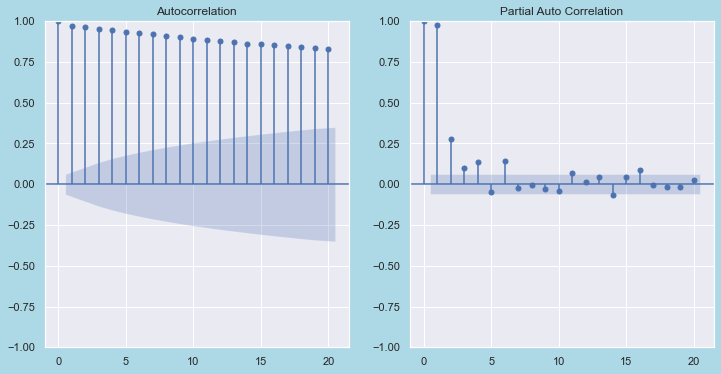

In [40]:
# ACF and PACF plots
ROWS = 1; COLS = 2
fig,ax = plt.subplots(ROWS,COLS,figsize=(12,6))
plot_acf(df0, lags=20, ax=ax[0]);
plt.title("Auto Correlation")

plot_pacf(df0, lags=20, ax=ax[1]);
plt.title("Partial Auto Correlation")

plt.show()

In [41]:
#train test split
sp=int(0.95*len(df0))
train=df0.iloc[:sp]
test=df0.iloc[sp:]

In [42]:
len(train),len(test)

(938, 50)

In [92]:
m0 = sm.tsa.statespace.SARIMAX(train,order=(4,1,3),seasonal_order=(2,1,1,52)).fit()

In [44]:
#actual ,forecasted and error for sales as forecasted by sarima model
start=len(train)
end=len(test)+len(train)-1
p=m0.predict(start,end)
dff2=pd.DataFrame({'actual':test.asin, 'forecasts':p.values})
#finding error actual-forecasted
dff2["error"]=dff2["actual"]-dff2["forecasts"]
dff2.head()

,actual,forecasts,error
reviewTime,,,
2017-10-29,240,198.538254,41.461746
2017-11-05,281,227.698559,53.301441
2017-11-12,261,223.433485,37.566515
2017-11-19,242,267.080709,-25.080709
2017-11-26,219,197.450233,21.549767


In [45]:
# Calcualating the MSE
mse = mean_squared_error(dff2.actual, dff2.forecasts) 
mse

4467.686504662676

Text(0.5, 1.0, 'SARIMA model')

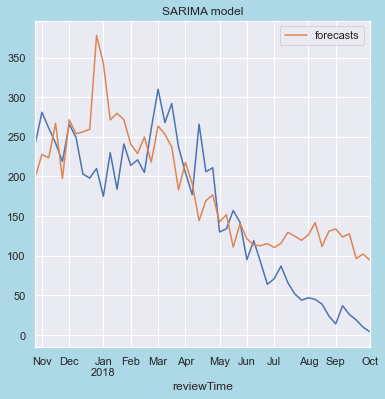

In [46]:
# plotting the actual and forecast data of the test data
dff2.actual.plot(figsize=(6,6))
dff2.forecasts.plot(legend=True)
plt.title("SARIMA model")

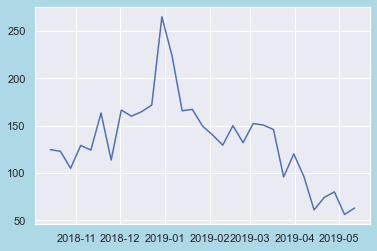

In [49]:
#forecasting for next 30 weeks
plt.plot(m0.predict(len(train)+len(test),len(train)+len(test)+30))

### Sentiment Forecasting

In [62]:
df=pd.read_csv("sentiment.csv")

In [63]:
df=df[["reviewTime","Class","compound"]]

In [64]:
df=pd.get_dummies(df,columns=["Class"])

In [25]:
df.head()

,reviewTime,compound,Class_neg,Class_neutral,Class_pos
0,2015-10-17,0.5719,0,0,1
1,2015-07-27,0.7947,0,0,1
2,2015-02-23,0.2960,0,0,1
3,2015-02-20,0.3400,0,0,1
4,2014-12-25,0.8934,0,0,1


In [65]:
df1=df.copy()

In [66]:
df=df[["reviewTime","Class_pos"]]

In [67]:
df=df.set_index("reviewTime")

In [68]:
df.head(10)

,Class_pos
reviewTime,
2015-10-17,1
2015-07-27,1
2015-02-23,1
2015-02-20,1
2014-12-25,1
2014-11-13,1
2014-08-02,0
2014-03-03,1
2014-02-21,1


In [69]:
df.index=pd.to_datetime(df.index)

In [70]:
df.index.is_monotonic_increasing

False

In [71]:
df=df.sort_index()

In [34]:
df=df.resample("M").mean()

In [59]:
df.tail(10)

,Class_pos
reviewTime,
2018-01-31,0.819180
2018-02-28,0.819867
2018-03-31,0.830924
2018-04-30,0.819684
2018-05-31,0.823789
2018-06-30,0.817292
2018-07-31,0.812352
2018-08-31,0.754717
2018-09-30,0.882353


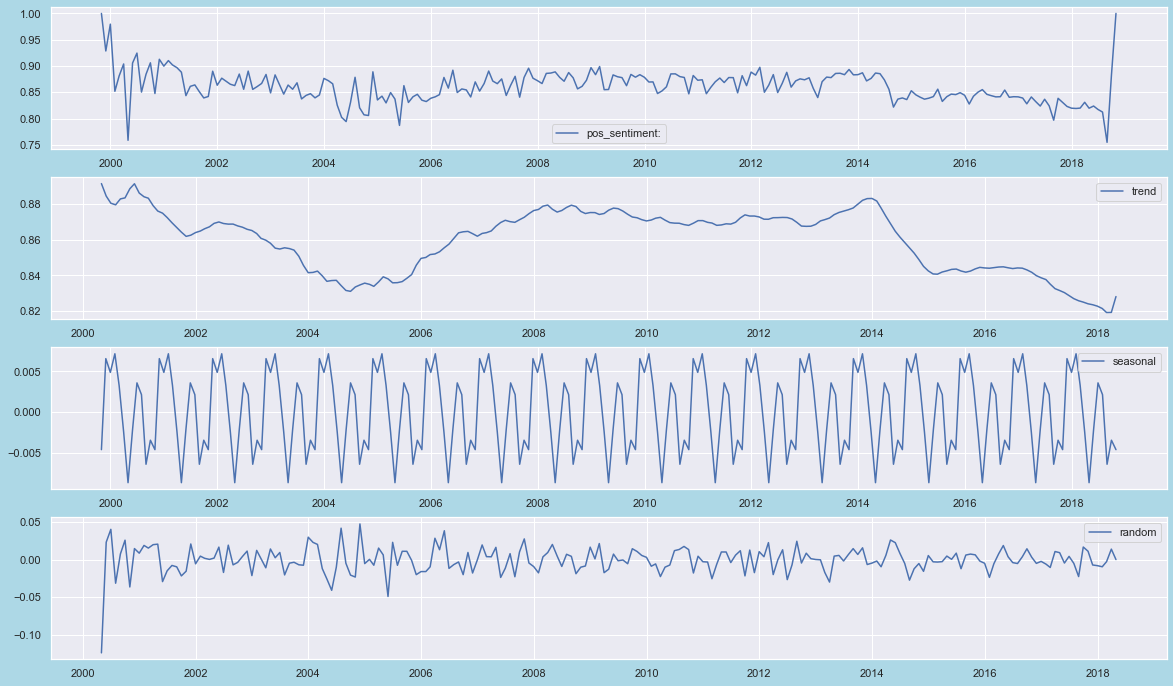

In [39]:
#visualizing the  time series components

decomp=seasonal_decompose(df)
trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid

fig,ax=plt.subplots(4,1,figsize=(20,12))

plt.subplot(411)
plt.plot(df,label="pos_sentiment:")
plt.legend()

plt.subplot(412)
plt.plot(trend,label="trend")
plt.legend()

plt.subplot(413)
plt.plot(seasonal,label="seasonal")
plt.legend()

plt.subplot(414)
plt.plot(residual,label="random")
plt.legend()
plt.show()


In [40]:
# ADF test to determine data stationarity
def checkStationarity(data):
    pvalue = adfuller(data)[1]

    if pvalue < 0.05:
        msg = "pvalue={}. Data is Stationary. Proceed to model building".format(pvalue)
    else:
        msg = "pvalue={}. Data is not Stationary. Make the data stationary before model building".format(pvalue)
    return(msg)

In [41]:
checkStationarity(df)

'pvalue=0.0010574292419848524. Data is Stationary. Proceed to model building'

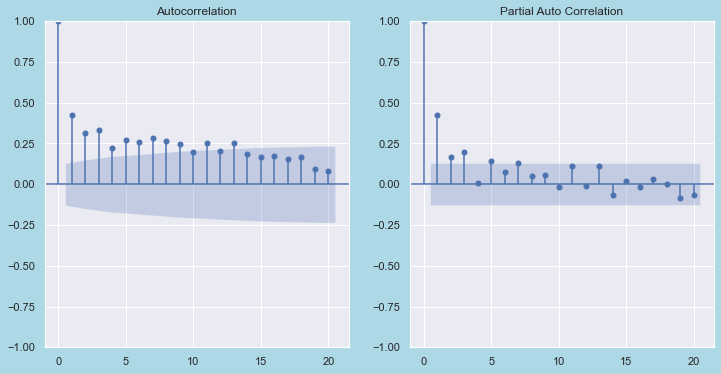

In [44]:
# ACF and PACF plots
ROWS = 1; COLS = 2
fig,ax = plt.subplots(ROWS,COLS,figsize=(12,6))
plot_acf(df, lags=20, ax=ax[0]);
plt.title("Auto Correlation")

plot_pacf(df, lags=20, ax=ax[1]);
plt.title("Partial Auto Correlation")

plt.show()

In [51]:
#train test split
sp=int(0.8*len(df))
train=df.iloc[:sp]
test=df.iloc[sp:]

In [52]:
m = sm.tsa.statespace.SARIMAX(train,order=(4,2,3),seasonal_order=(2,1,1,52)).fit()

C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [53]:
start=len(train)
end=len(test)+len(train)-1
p=m.predict(start,end)
dff2=pd.DataFrame({'actual':test.Class_pos, 'forecasts':p.values})
#finding error actual-forecasted
dff2["error"]=dff2["actual"]-dff2["forecasts"]
dff2.head()

,actual,forecasts,error
reviewTime,,,
2015-01-31,0.845131,0.851010,-0.005879
2015-02-28,0.840824,0.819673,0.021150
2015-03-31,0.836867,0.840691,-0.003825
2015-04-30,0.838761,0.832637,0.006123
2015-05-31,0.841773,0.834156,0.007617


In [54]:
# Calcualating the MSE
mse = mean_squared_error(dff2.actual, dff2.forecasts) 
mse

0.0013408672562390395

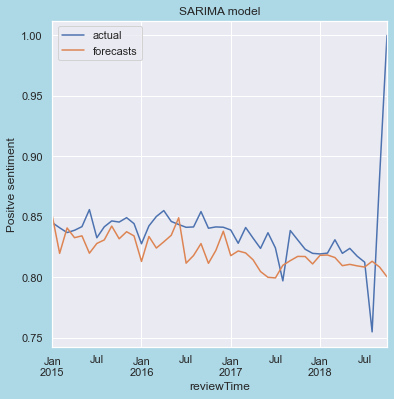

In [84]:
dff2.actual.plot(figsize=(6,6))
dff2.forecasts.plot(legend=True)
plt.title("SARIMA model")
plt.ylabel("Positve sentiment")
plt.legend(loc="upper left")

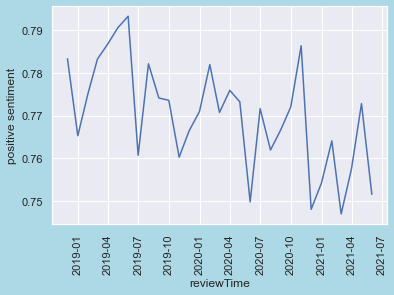

In [80]:
plt.plot(m.predict(len(train)+len(test),len(train)+len(test)+30))
plt.xticks(rotation=90)
plt.xlabel("reviewTime")
plt.ylabel("positive sentiment")
plt.show()

### Sentiments on different products

In [86]:
df=pd.read_csv("sentiment.csv")
df.head()

,Unnamed: 0,Class,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,category,brand,rank,platform,neg,neu,pos,compound
0,0,pos,5.0,True,2015-10-17,A1HP7NVNPFMA4N,0700026657,game bit hard get hang great,great,Games,ubisoft,30230,PC,0.147,0.421,0.432,0.5719
1,1,pos,4.0,False,2015-07-27,A1JGAP0185YJI6,0700026657,played alright steam bit trouble move game ste...,spite fun liked,Games,ubisoft,30230,PC,0.197,0.368,0.435,0.7947
2,2,pos,3.0,True,2015-02-23,A1YJWEXHQBWK2B,0700026657,ok game,three stars,Games,ubisoft,30230,PC,0.000,0.312,0.688,0.2960
3,3,pos,2.0,True,2015-02-20,A2204E1TH211HT,0700026657,found game bit complicated expected played,two stars,Games,ubisoft,30230,PC,0.000,0.676,0.324,0.3400
4,4,pos,5.0,True,2014-12-25,A2RF5B5H74JLPE,0700026657,great game love played since arrived,love game,Games,ubisoft,30230,PC,0.000,0.219,0.781,0.8934


<AxesSubplot:xlabel='category', ylabel='count'>

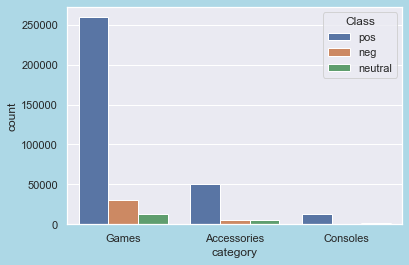

In [87]:
sns.countplot(data=df,x="category",hue="Class")

<AxesSubplot:xlabel='platform', ylabel='count'>

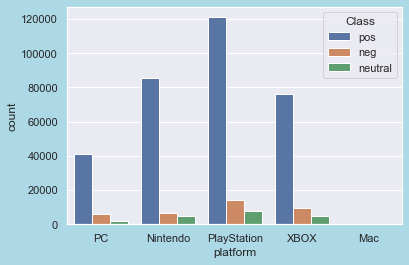

In [93]:
sns.countplot(data=df,x="platform",hue="Class")

In [91]:
pd.crosstab(index=df["Class"],columns=df["category"],normalize='columns')

category,Accessories,Consoles,Games
Class,,,
neg,0.081607,0.062770,0.099296
neutral,0.081689,0.066676,0.043037
pos,0.836704,0.870554,0.857667


In [92]:
pd.crosstab(index=df["Class"],columns=df["platform"],normalize='columns')

platform,Mac,Nintendo,PC,PlayStation,XBOX
Class,,,,,
neg,0.130769,0.068477,0.119812,0.098772,0.104329
neutral,0.023077,0.051009,0.038098,0.052541,0.052098
pos,0.846154,0.880514,0.842090,0.848686,0.843573


In [95]:
pd.crosstab(index=df["Class"],columns=df["verified"],normalize='columns')

verified,False,True
Class,,
neg,0.134557,0.073291
neutral,0.017338,0.068266
pos,0.848105,0.858443


In [96]:
pd.crosstab(index=df["Class"],columns=df["verified"])

verified,False,True
Class,,
neg,18075,17869
neutral,2329,16644
pos,113926,209297
